# Задача "Прогноз состава сырья"

## Описание задачи
На нефтехимические заводы СИБУР сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.

Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

Вам предстоит построить прогноз состава поступающей по трубопроводу ШФЛУ на основании данных с последней перед потребителем станции подкачки. При этом геометрия трубопровода, расстояние от станции подкачки до потребителя и другие параметры трубопровода не раскрываются.

Метрикой в этой задаче служит средняя по всем целевым переменным MAPE.

## Данные
Данные содержат расходы сырья в т/ч для станции подкачки A (A_rate) и потребителя B (B_rate), а также массовые процентные доли различных компонент на станции A (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

Целевые переменные: массовые процентные доли нескольких компонент на станции B (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10). Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

train_targets.csv - целевые переменные для тренировочного множества
train_features.csv - признаки для тренировочного множества
test_features.csv - признаки для тестового множества
sample_submission.csv - пример решения в правильном формате

## Вебинар
На вебинаре организаторы разъяснили немного условия задачи.
Есть трубопровод по которому подается ШФЛУ из сечения А в сечение В. По пути из А в В присутствует подкачка ШФЛУ более-менее стабильного состава. Расход данной подкачки можно определить на основании данных в условии задачи расходов в А и В.

G - массовый расход ШФЛУ, х - процентный массовый состав ШФЛУ по каждому компоненту

<center>
<img src="Schem.jpg">

Первое что приходит в голову - задача на **структуру потоков**.

Если бы были данные по устройству трубопровода (геометрия, топология, арматура), температура и давление ШФЛУ, результаты гидродинамических испытаний по структуре потока (кривые распределения времени пребывания, плотности распределения, кривые отклика) можно было бы попытаться создать модель (ячеечную или диффузионную), а также попробовать её решить численно, либо создать гибридную модель. Но данных таких нет и не всегда они бывают даже у датасайнтистов из Сибура...
    
    
Кстати, в интернете нашел интересную статью как раз по моделированию смешения и коэффициента продольного перемешивания (эффективная диффузия) - "*Новый метод расчета многопродуктовых магистральных
трубопроводов*", А.С. Дидковская

## Посмотрим на данные

In [501]:
import numpy as np
import pandas as pd
import seaborn as sns
import math as m

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [502]:
import warnings
warnings.filterwarnings('ignore')

In [503]:
train_features = pd.read_csv('train_features.csv', header = 0, sep = ',')
test_features = pd.read_csv('test_features.csv', header = 0, sep = ',')
train_target = pd.read_csv('train_targets.csv', header = 0, sep = ',')

In [504]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [505]:
train_features[:]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 00:00:00  70.855017       NaN       NaN        NaN   
1     2020-01-01 00:30:00  70.826582       NaN       NaN        NaN   
2     2020-01-01 01:00:00  70.809637       NaN       NaN        NaN   
3     2020-01-01 01:30:00  69.994748       NaN       NaN        NaN   
4     2020-01-01 02:00:00  70.072762       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5803  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5804  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5805  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5806  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5807  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0           NaN        NaN       NaN       NaN       NaN  71.982789  
1           NaN        NaN       NaN       NaN       NaN  71.965098  
2           NaN        NaN       NaN       NaN       NaN  71.867409  
3           NaN        NaN       NaN       NaN       NaN  71.839126  
4           NaN        NaN       NaN       NaN       NaN  71.336921  
...         ...        ...       ...       ...       ...        ...  
5803  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  

[5808 rows x 11 columns]

In [506]:
train_features.corr()

A_rate     A_CH4    A_C2H6    A_C3H8  A_iC4H10  A_nC4H10  \
A_rate    1.000000  0.140528  0.437019  0.418836  0.017336 -0.430159   
A_CH4     0.140528  1.000000  0.335366  0.200776 -0.154180 -0.337805   
A_C2H6    0.437019  0.335366  1.000000  0.527549 -0.100987 -0.701938   
A_C3H8    0.418836  0.200776  0.527549  1.000000  0.486148 -0.709767   
A_iC4H10  0.017336 -0.154180 -0.100987  0.486148  1.000000  0.199295   
A_nC4H10 -0.430159 -0.337805 -0.701938 -0.709767  0.199295  1.000000   
A_iC5H12 -0.399400 -0.150923 -0.514814 -0.940113 -0.645688  0.546690   
A_nC5H12 -0.367528 -0.155106 -0.540416 -0.930008 -0.659884  0.523956   
A_C6H14  -0.318311 -0.128191 -0.407348 -0.881589 -0.686246  0.384840   
B_rate    0.962491  0.051154  0.341268  0.231222 -0.167036 -0.273329   

          A_iC5H12  A_nC5H12   A_C6H14    B_rate  
A_rate   -0.399400 -0.367528 -0.318311  0.962491  
A_CH4    -0.150923 -0.155106 -0.128191  0.051154  
A_C2H6   -0.514814 -0.540416 -0.407348  0.341268  
A_C3H8   -0.940113 -0.930008 -0.881589  0.231222  
A_iC4H10 -0.645688 -0.659884 -0.686246 -0.167036  
A_nC4H10  0.546690  0.523956  0.384840 -0.273329  
A_iC5H12  1.000000  0.975426  0.862518 -0.224065  
A_nC5H12  0.975426  1.000000  0.877563 -0.178315  
A_C6H14   0.862518  0.877563  1.000000 -0.122962  
B_rate   -0.224065 -0.178315 -0.122962  1.000000

In [507]:
train_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  5807.000000  4849.000000  4849.000000  4849.000000  4849.000000   
mean     59.346948     0.159890     4.290739    37.990406    17.343168   
std      20.684895     0.068488     0.912565     3.756424     0.754301   
min       0.000321     0.008045     0.280524    11.345740    11.143152   
25%      61.846908     0.109331     3.971011    37.647968    17.018272   
50%      67.010148     0.139924     4.485758    38.618187    17.327200   
75%      69.734038     0.212163     4.844390    39.402360    17.685803   
max      74.560399     0.471429     6.418897    42.860283    20.353500   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  4849.000000  4849.000000  4849.000000  4849.000000  5675.000000  
mean     24.413897     4.948636     4.809805     5.995740    64.817202  
std       1.274795     1.230539     1.285549     1.543956    10.696414  
min      18.655932     3.033678     1.338103     2.924722     0.000000  
25%      23.746663     4.462670     4.353103     5.574106    63.852030  
50%      24.138643     4.684908     4.619459     5.708216    68.583359  
75%      24.615843     5.086816     4.925770     6.032535    71.171153  
max      35.498867    13.812560    14.845480    30.656385    89.958390

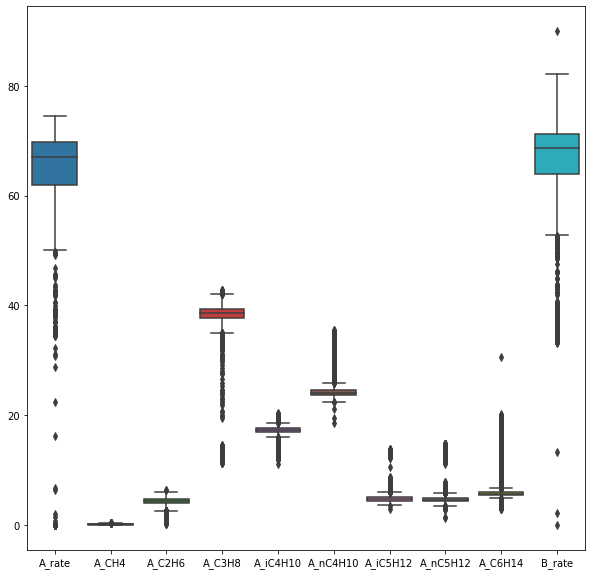

In [508]:
plt.rcParams["figure.figsize"] = (10,10)
sns.boxplot(data=train_features)

In [509]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [510]:
train_features.info()
train_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
timestamp    5808 non-null object
A_rate       5807 non-null float64
A_CH4        4849 non-null float64
A_C2H6       4849 non-null float64
A_C3H8       4849 non-null float64
A_iC4H10     4849 non-null float64
A_nC4H10     4849 non-null float64
A_iC5H12     4849 non-null float64
A_nC5H12     4849 non-null float64
A_C6H14      4849 non-null float64
B_rate       5675 non-null float64
dtypes: float64(10), object(1)
memory usage: 499.2+ KB


(5808, 11)

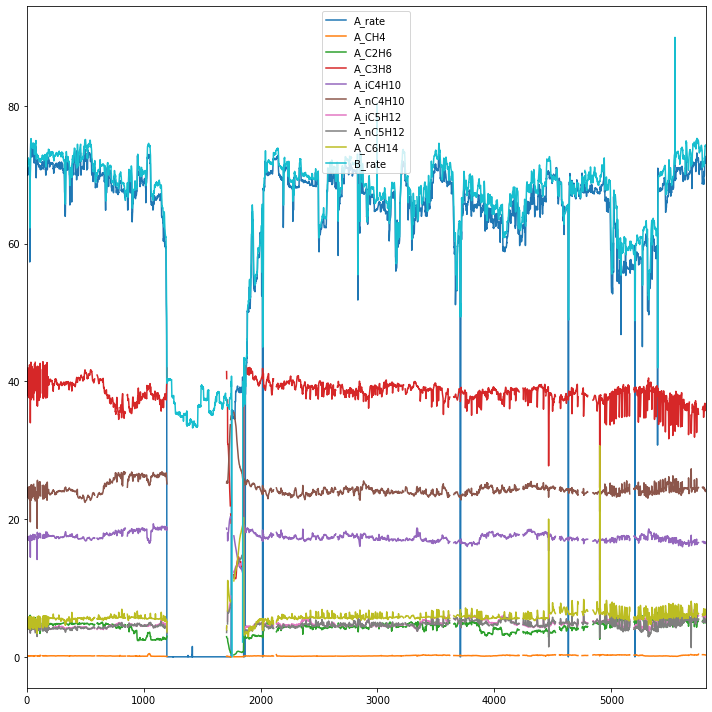

In [511]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [512]:
train_features[train_features["A_rate"] <= 40]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
1197  2020-01-25 22:30:00  37.634787  0.068959  2.783333  39.613317   
1198  2020-01-25 23:00:00   0.001294  0.070249  2.903388  41.168760   
1199  2020-01-25 23:30:00   0.001701  0.071737  2.994731  41.935570   
1200  2020-01-26 00:00:00   0.001525       NaN       NaN        NaN   
1201  2020-01-26 00:30:00   0.001055       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5201  2020-04-18 08:30:00  39.827838  0.240746  5.309529  38.752616   
5202  2020-04-18 09:00:00   0.002014  0.247586  5.250514  38.680070   
5203  2020-04-18 09:30:00   0.001633  0.261290  4.818443  38.907820   
5204  2020-04-18 10:00:00  38.215334  0.276025  4.567278  38.848842   
5396  2020-04-22 10:00:00  30.749718  0.110907  5.681407  38.414870   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
1197  18.374810  25.521723  4.473425  3.987337  5.163005  45.833590  
1198  18.650220  25.298560  4.232059  3.601516  4.062176  42.446206  
1199  18.765710  25.119170  4.089573  3.390231  3.620386  39.727496  
1200        NaN        NaN       NaN       NaN       NaN  39.972873  
1201        NaN        NaN       NaN       NaN       NaN  40.089745  
...         ...        ...       ...       ...       ...        ...  
5201  17.415626  24.286268  4.272327  4.035304  5.629434  56.099281  
5202  17.369883  24.286207  4.326687  4.089799  5.691831  48.813637  
5203  17.416410  24.441860  4.462670  4.187992  5.451690  49.964670  
5204  17.454773  24.491840  4.555090  4.260572  5.496899  48.964665  
5396  17.581315  24.102620  4.432917  3.888675  5.740080  54.846246  

[694 rows x 11 columns]

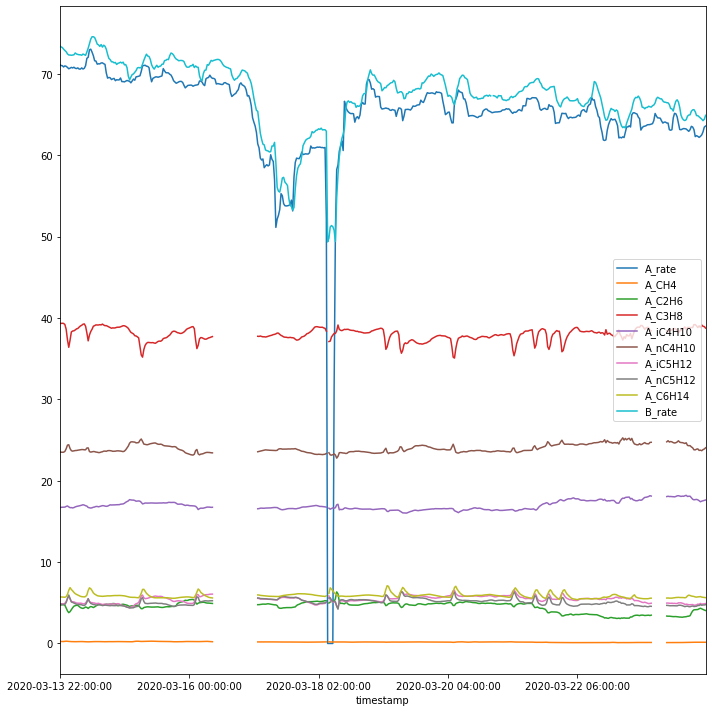

In [513]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[3500:4000].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [514]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447  
...         ...        ...       ...       ...       ...        ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667  

[3984 rows x 11 columns]

In [515]:
test_features.isnull().sum()

timestamp       0
A_rate       1142
A_CH4         456
A_C2H6        451
A_C3H8        452
A_iC4H10      452
A_nC4H10      452
A_iC5H12      456
A_nC5H12      456
A_C6H14       455
B_rate          5
dtype: int64

In [516]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
timestamp    3984 non-null object
A_rate       2842 non-null float64
A_CH4        3528 non-null float64
A_C2H6       3533 non-null float64
A_C3H8       3532 non-null float64
A_iC4H10     3532 non-null float64
A_nC4H10     3532 non-null float64
A_iC5H12     3528 non-null float64
A_nC5H12     3528 non-null float64
A_C6H14      3529 non-null float64
B_rate       3979 non-null float64
dtypes: float64(10), object(1)
memory usage: 342.5+ KB


(3984, 11)

In [517]:
test_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  2842.000000  3528.000000  3533.000000  3532.000000  3532.000000   
mean     69.884320     0.162207     4.467679    39.109041    17.397629   
std       2.975072     0.051789     0.475805     2.194943     1.178583   
min       0.001292     0.000000     0.000000     3.891164     0.000000   
25%      69.168728     0.126446     4.236493    38.392097    16.856905   
50%      70.152686     0.147803     4.464768    39.061776    17.276783   
75%      71.289177     0.173982     4.731939    40.305470    18.068539   
max      74.346769     0.390817     6.551086   100.000000    54.028570   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  3532.000000  3528.000000  3528.000000  3529.000000  3979.000000  
mean     23.899568     4.871338     4.450333     5.613259    72.461288  
std       0.851144     0.629635     0.666401     2.049381     2.221912  
min       0.000000     0.000000     0.000000     0.000000    44.154610  
25%      23.579122     4.381023     3.842573     4.748398    71.653297  
50%      23.898327     4.775210     4.565247     5.943392    72.612522  
75%      24.259839     5.196619     4.922047     6.127190    73.800168  
max      34.284363    13.819660    11.846500    83.718820    94.243585

По максимальным значениям можно обнаружить наличие выбросов

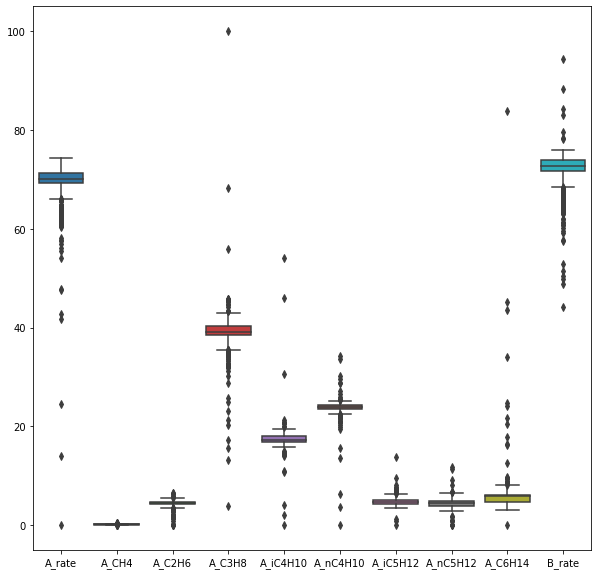

In [518]:
sns.boxplot(data=test_features)

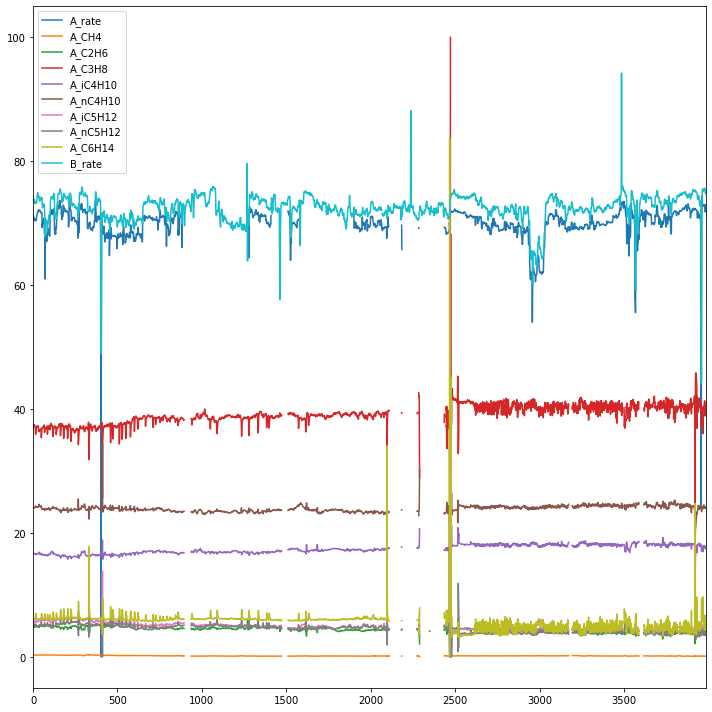

In [519]:
plt.rcParams["figure.figsize"] = (10,10)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [520]:
#dict_clean = {'A_C3H8':45, 'A_iC4H10':30, 'A_C6H14':15}

In [521]:
#for i in range(1,test_features.shape[0]):
#    for j in dict_clean:
#        if test_features.loc[i,j] > dict_clean[j]:
#            test_features.loc[[i],[j]] = test_features.loc[[i-1],[j]]

In [522]:
train_target[:]

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0     2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1     2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2     2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3     2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4     2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510
...                   ...       ...        ...        ...        ...
5803  2020-04-30 21:30:00  4.816865  35.539156  16.269938  24.770377
5804  2020-04-30 22:00:00  4.993286  36.067750  16.317757  24.729847
5805  2020-04-30 22:30:00  5.101574  36.275040  16.295460  24.629889
5806  2020-04-30 23:00:00  5.210675  36.872917  16.336359  24.438236
5807  2020-04-30 23:30:00  5.136487  35.860326  16.101509  24.426845

[5808 rows x 5 columns]

In [523]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [524]:
train_target.info()
train_target.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
timestamp    5808 non-null object
B_C2H6       5624 non-null float64
B_C3H8       5628 non-null float64
B_iC4H10     5628 non-null float64
B_nC4H10     5628 non-null float64
dtypes: float64(4), object(1)
memory usage: 227.0+ KB


(5808, 5)

In [525]:
train_target.describe()

B_C2H6       B_C3H8     B_iC4H10     B_nC4H10
count  5624.000000  5628.000000  5628.000000  5628.000000
mean      4.363701    37.742757    16.843028    24.171264
std       2.931240     2.218569     1.059827     1.480740
min       0.861025     0.026142     0.012764     0.019941
25%       3.503610    36.827096    16.548084    23.736470
50%       4.395271    37.750088    16.934576    24.147675
75%       4.680156    38.730979    17.292647    24.642044
max      91.573613    61.931856    19.235807    27.184879

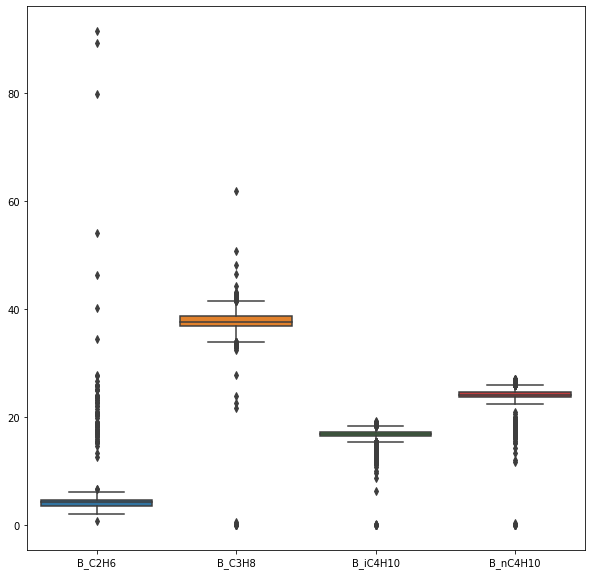

In [526]:
sns.boxplot(data=train_target)

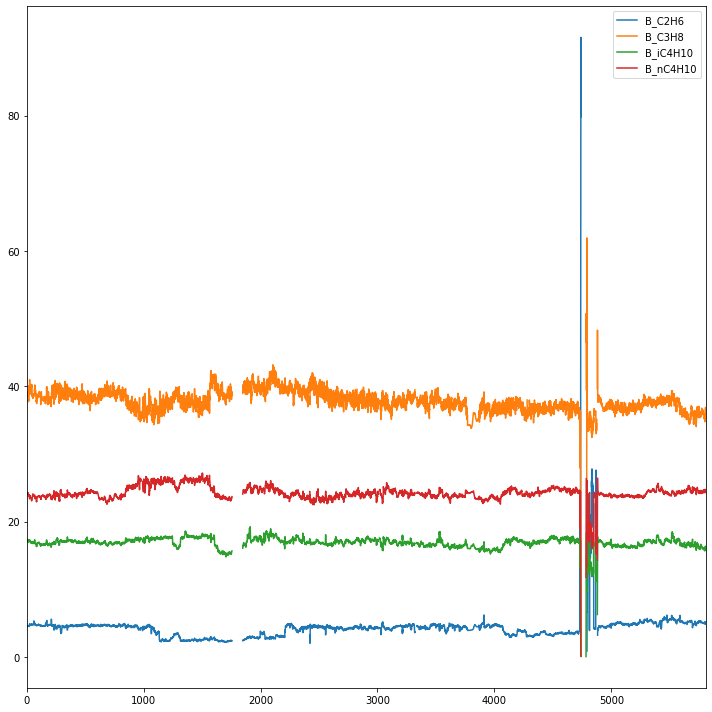

In [527]:
plt.rcParams["figure.figsize"] = (10,10)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

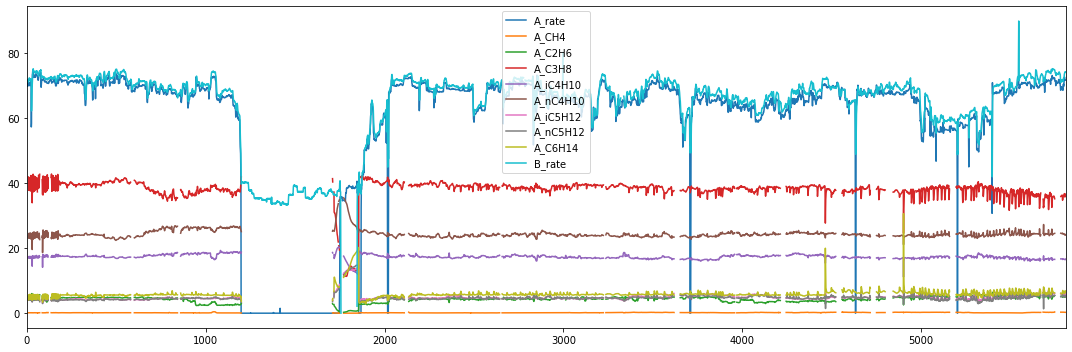

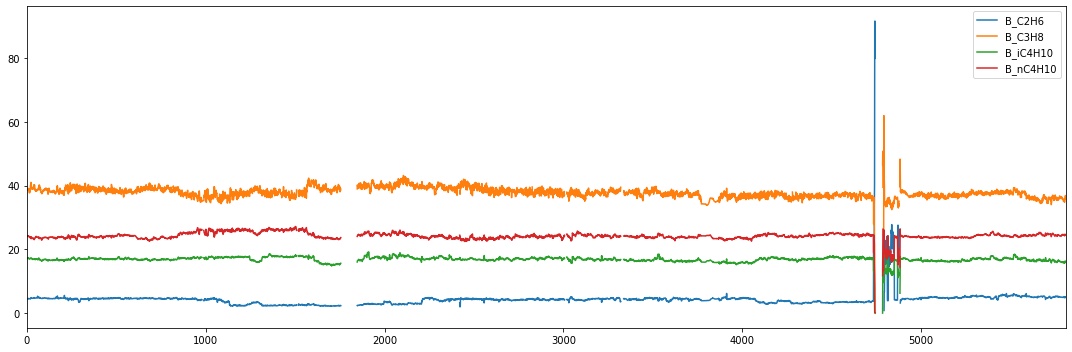

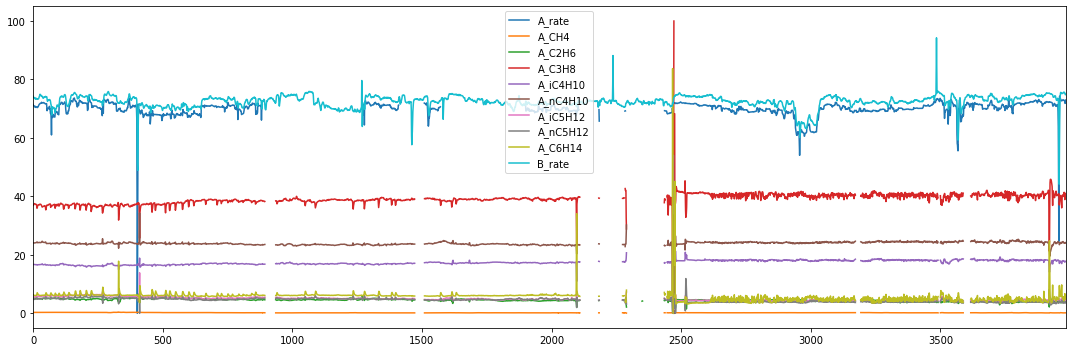

In [528]:
plt.rcParams["figure.figsize"] = (15,5)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [529]:
#dict_clean = {'B_C2H6':30, 'B_C3H8':50}

In [530]:
#for i in range(1,train_target.shape[0]):
#    for j in dict_clean:
#        if train_target.loc[i,j] > dict_clean[j]:
#            train_target.loc[[i],[j]] = train_target.loc[[i-1],[j]]

## Трансформация датасета

Попробуем оценить кажущийся отклик

In [531]:
train_features[['A_rate','B_rate']]

A_rate     B_rate
0     70.855017  71.982789
1     70.826582  71.965098
2     70.809637  71.867409
3     69.994748  71.839126
4     70.072762  71.336921
...         ...        ...
5803  72.009730  74.183355
5804  71.854180  74.213066
5805  71.783273  74.144367
5806  71.717743  74.320575
5807  71.730325  74.327170

[5808 rows x 2 columns]

In [532]:
derivatives_A = pd.DataFrame()
derivatives_B = pd.DataFrame()

derivatives_A['der_A_rate']=[]
derivatives_B ['der_B_rate']=[]

for i in range(train_features[['A_rate','B_rate']].shape[1]):
    for j in range(train_features[['A_rate','B_rate']].shape[0]-1):
        x = train_features[['A_rate','B_rate']].iloc[j,i]
        y = train_features[['A_rate','B_rate']].iloc[j+1,i]
        
        if i == 0:
            new_line = {'der_A_rate':(y-x)/30}
            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
        else:
            new_line = {'der_B_rate':(y-x)/30}
            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [533]:
derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
derivatives

der_A_rate  der_B_rate
0      -0.000948   -0.000590
1      -0.000565   -0.003256
2      -0.027163   -0.000943
3       0.002600   -0.016740
4      -0.002479   -0.000636
...          ...         ...
5802   -0.008466    0.006174
5803   -0.005185    0.000990
5804   -0.002364   -0.002290
5805   -0.002184    0.005874
5806    0.000419    0.000220

[5807 rows x 2 columns]

In [534]:
# Сдвиг по времени 0
(derivatives['der_A_rate'] - derivatives['der_B_rate']).apply(np.abs).mean()

0.016707230655472926

In [535]:
# Сдвиг по времени 30 минут
x = derivatives['der_A_rate'][0:-1]
y = derivatives['der_B_rate'][1:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.012438913385618582

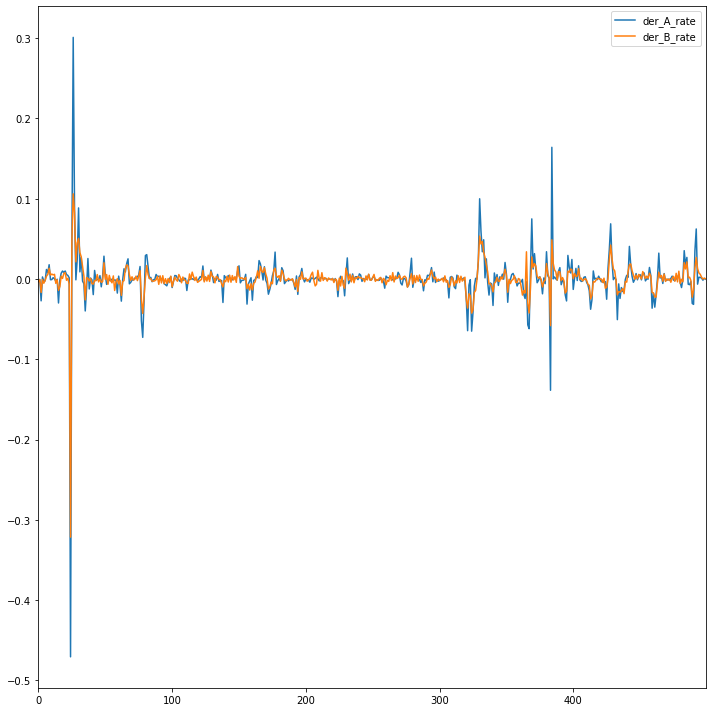

In [536]:
plt.rcParams["figure.figsize"] = (10,10)

z[0:500].plot()

# make room for tick labels
plt.tight_layout()

plt.show()

In [537]:
# Сдвиг по времени 60 минут
x = derivatives['der_A_rate'][0:-2]
y = derivatives['der_B_rate'][2:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.01659637858206412

In [538]:
# Сдвиг по времени 90 минут
x = derivatives['der_A_rate'][0:-3]
y = derivatives['der_B_rate'][3:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.0191065411244112

Кажущийся отклик по расходу: 30 минут +- 15 минут

In [539]:
data = pd.concat([train_features,train_target.drop(['timestamp'], axis=1)], axis=1)
data.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
B_C2H6       184
B_C3H8       180
B_iC4H10     180
B_nC4H10     180
dtype: int64

In [540]:
data = data.ffill(axis = 0)
data.isnull().sum()

timestamp    0
A_rate       0
A_CH4        9
A_C2H6       9
A_C3H8       9
A_iC4H10     9
A_nC4H10     9
A_iC5H12     9
A_nC5H12     9
A_C6H14      9
B_rate       0
B_C2H6       0
B_C3H8       0
B_iC4H10     0
B_nC4H10     0
dtype: int64

In [541]:
NaNList = []
x = (data.isnull().sum(axis=1) > 0)
for i in range(x.shape[0]):
    if x[i] == True:
        NaNList.append(i)
data.drop(NaNList, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [542]:
data

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480   
1     2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330   
2     2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656   
3     2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493   
4     2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510   
...                   ...        ...       ...       ...        ...   
5794  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5795  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5796  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5797  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5798  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6  \
0     17.064213  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649   
1     17.440245  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543   
2     17.353362  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879   
3     17.098163  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837   
4     16.964787  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611   
...         ...        ...       ...       ...       ...        ...       ...   
5794  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  4.816865   
5795  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  4.993286   
5796  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  5.101574   
5797  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  5.210675   
5798  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  5.136487   

         B_C3H8   B_iC4H10   B_nC4H10  
0     38.604149  17.238489  24.275393  
1     38.510623  17.193441  24.242152  
2     39.124029  17.301609  24.211492  
3     38.247333  17.118282  24.044074  
4     37.985776  17.038811  23.931490  
...         ...        ...        ...  
5794  35.539156  16.269938  24.770377  
5795  36.067750  16.317757  24.729847  
5796  36.275040  16.295460  24.629889  
5797  36.872917  16.336359  24.438236  
5798  35.860326  16.101509  24.426845  

[5799 rows x 15 columns]

In [543]:
data_prev = data
data = data.rolling(24, min_periods=0).mean()

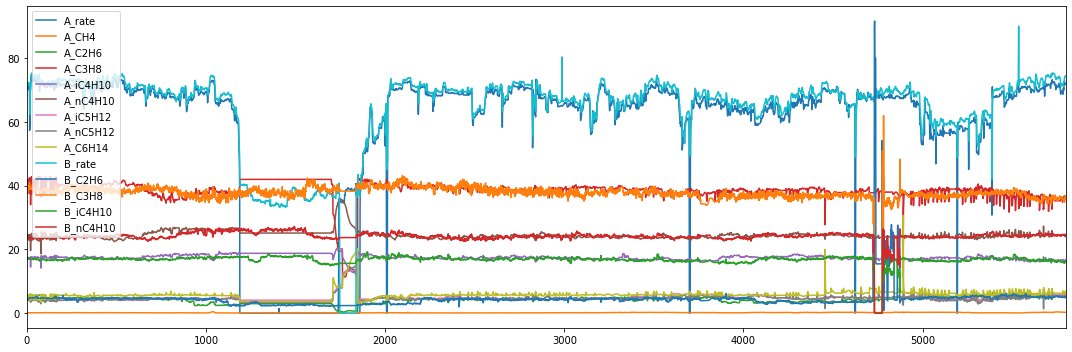

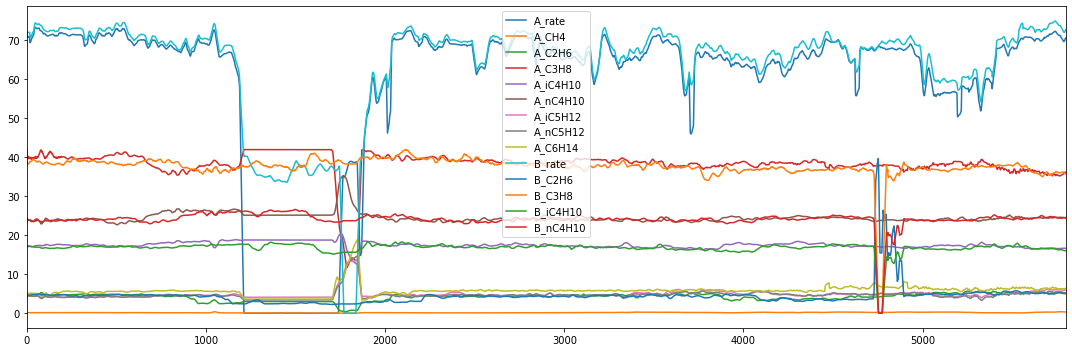

In [544]:
plt.rcParams["figure.figsize"] = (15,5)
data_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

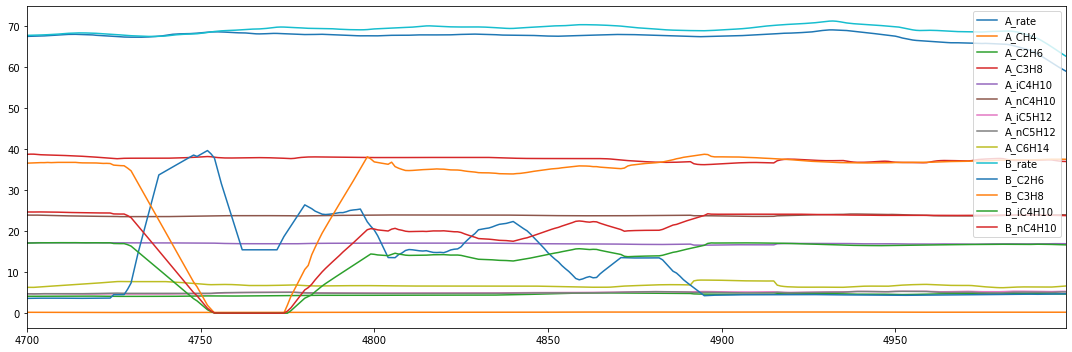

In [545]:
plt.rcParams["figure.figsize"] = (15,5)
data[4700:5000].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [546]:
data[data[:] < 0].isnull().sum()

A_rate      5799
A_CH4       5799
A_C2H6      5799
A_C3H8      5799
A_iC4H10    5799
A_nC4H10    5799
A_iC5H12    5799
A_nC5H12    5799
A_C6H14     5799
B_rate      5799
B_C2H6      5799
B_C3H8      5799
B_iC4H10    5799
B_nC4H10    5799
dtype: int64

In [547]:
data['timestamp'] = data_prev['timestamp']
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5794  70.067458  0.308936  5.088560  36.093939  16.659283  24.456223   
5795  70.195171  0.307568  5.080191  36.091638  16.648055  24.433390   
5796  70.320771  0.305932  5.073049  36.105212  16.639073  24.408832   
5797  70.437162  0.303769  5.064262  36.128161  16.631952  24.386567   
5798  70.537988  0.301398  5.055399  36.150185  16.628783  24.371108   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5794  5.900810  5.190308  6.245862  72.155353  5.010789  35.744676  15.992008   
5795  5.904263  5.202483  6.276430  72.287969  5.009568  35.745256  16.001410   
5796  5.900870  5.204381  6.306800  72.404857  5.012571  35.758582  16.013955   
5797  5.896023  5.202612  6.330998  72.530098  5.020124  35.783279  16.027707   
5798  5.888891  5.198700  6.350054  72.652285  5.023277  35.755455  16.026055   

       B_nC4H10            timestamp  
0     24.275393  2020-01-01 04:30:00  
1     24.258773  2020-01-01 05:00:00  
2     24.243013  2020-01-01 05:30:00  
3     24.193278  2020-01-01 06:00:00  
4     24.140920  2020-01-01 06:30:00  
...         ...                  ...  
5794  24.471412  2020-04-30 21:30:00  
5795  24.491825  2020-04-30 22:00:00  
5796  24.510630  2020-04-30 22:30:00  
5797  24.520887  2020-04-30 23:00:00  
5798  24.525772  2020-04-30 23:30:00  

[5799 rows x 15 columns]

In [548]:
monthList =[]
for i in data['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [549]:
data['month'] = monthList

In [550]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5794  70.067458  0.308936  5.088560  36.093939  16.659283  24.456223   
5795  70.195171  0.307568  5.080191  36.091638  16.648055  24.433390   
5796  70.320771  0.305932  5.073049  36.105212  16.639073  24.408832   
5797  70.437162  0.303769  5.064262  36.128161  16.631952  24.386567   
5798  70.537988  0.301398  5.055399  36.150185  16.628783  24.371108   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5794  5.900810  5.190308  6.245862  72.155353  5.010789  35.744676  15.992008   
5795  5.904263  5.202483  6.276430  72.287969  5.009568  35.745256  16.001410   
5796  5.900870  5.204381  6.306800  72.404857  5.012571  35.758582  16.013955   
5797  5.896023  5.202612  6.330998  72.530098  5.020124  35.783279  16.027707   
5798  5.888891  5.198700  6.350054  72.652285  5.023277  35.755455  16.026055   

       B_nC4H10            timestamp  month  
0     24.275393  2020-01-01 04:30:00      1  
1     24.258773  2020-01-01 05:00:00      1  
2     24.243013  2020-01-01 05:30:00      1  
3     24.193278  2020-01-01 06:00:00      1  
4     24.140920  2020-01-01 06:30:00      1  
...         ...                  ...    ...  
5794  24.471412  2020-04-30 21:30:00      4  
5795  24.491825  2020-04-30 22:00:00      4  
5796  24.510630  2020-04-30 22:30:00      4  
5797  24.520887  2020-04-30 23:00:00      4  
5798  24.525772  2020-04-30 23:30:00      4  

[5799 rows x 16 columns]

In [551]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month'],
      dtype='object')

In [552]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

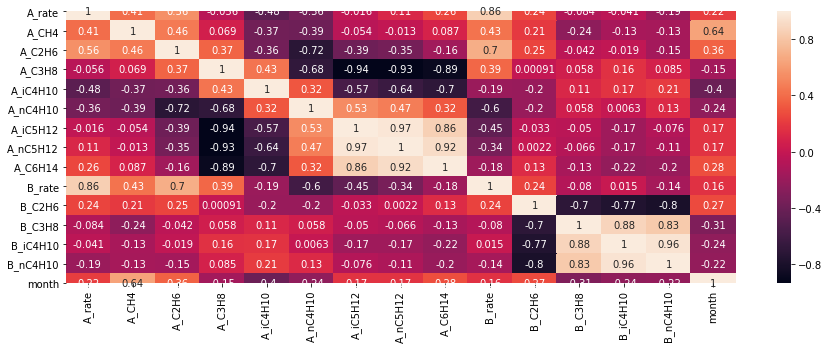

In [553]:
sns.heatmap(data.corr(), annot=True)

По [1] выпишем плотности сжиженных газов при 0 град Цельсия:

In [554]:
# кг/м3
ro_CH4 = 300.0 #Не нашел, указал из логических соображений
ro_C2H6 = 404.8
ro_C3H8 = 529.7
ro_iC4H10 = 581.0
ro_nC4H10 = 601.0
ro_iC5H12 = 639.2
ro_nC5H12 = 645.5
ro_C6H14 = 677.2

по [2] стр 65 выпишем динамическую вязкость сжиженных газов при 0 град Цельсия:

In [555]:
# Па*с
mu_CH4 = 10e-6 #Не нашел, указал из логических соображений
mu_C2H6 = 65e-6
mu_C3H8 = 140e-6
mu_iC4H10 = 225e-6
mu_nC4H10 = 215e-6
mu_iC5H12 = 285e-6
mu_nC5H12 = 295e-6
mu_C6H14 = 360e-6 #Не нашел, указал из логических соображений

по [3] выпишем молярные массы:

In [556]:
# кг/кмоль
M_CH4 = 16.04
M_C2H6 = 30.07
M_C3H8 = 44.1
M_iC4H10 = 58.12
M_nC4H10 = 58.12
M_iC5H12 = 72.15
M_nC5H12 = 72.15
M_C6H14 = 86.18

In [557]:
data['G_A_CH4'] = data['A_rate'] * data['A_CH4'] / 100
data['G_A_C2H6'] = data['A_rate'] * data['A_C2H6'] / 100
data['G_A_C3H8'] = data['A_rate'] * data['A_C3H8'] / 100
data['G_A_iC4H10'] = data['A_rate'] * data['A_iC4H10'] / 100
data['G_A_nC4H10'] = data['A_rate'] * data['A_nC4H10'] / 100
data['G_A_iC5H12'] = data['A_rate'] * data['A_iC5H12'] / 100
data['G_A_nC5H12'] = data['A_rate'] * data['A_nC5H12'] / 100
data['G_A_C6H14'] = data['A_rate'] * data['A_C6H14'] / 100

data['G_B_C2H6'] = data['B_rate'] * data['B_C2H6'] / 100
data['G_B_C3H8'] = data['B_rate'] * data['B_C3H8'] / 100
data['G_B_iC4H10'] = data['B_rate'] * data['B_iC4H10'] / 100
data['G_B_nC4H10'] = data['B_rate'] * data['B_nC4H10'] / 100

In [558]:
data['ro_mix_A'] = ((data['A_CH4'] / 100 / ro_CH4) + (data['A_C2H6'] / 100 / ro_C2H6) 
                  + (data['A_C3H8'] / 100 / ro_C3H8) + (data['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (data['A_nC4H10'] / 100 / ro_nC4H10) + (data['A_iC5H12'] / 100 / ro_iC5H12)
                  + (data['A_nC5H12'] / 100 / ro_nC5H12) + (data['A_C6H14'] / 100 / ro_C6H14))**-1

In [559]:
data['mu_mix_A'] = (((data['A_CH4'] / 100) * (data['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((data['A_C2H6'] / 100) * (data['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((data['A_C3H8'] / 100) * (data['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((data['A_iC4H10'] / 100) * (data['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((data['A_nC4H10'] / 100) * (data['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((data['A_iC5H12'] / 100) * (data['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((data['A_nC5H12'] / 100) * (data['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((data['A_C6H14'] / 100) * (data['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [560]:
data['w_A'] = (4*data['A_rate']*0.278)/(3.14*data['ro_mix_A']*0.16)
data['Re_A'] = (4*data['A_rate']*0.278)/(3.14*0.4*data['mu_mix_A'])

In [561]:
data['A_rate**2'] = data['A_rate']**2
data['sqrt_A_rate'] = data['A_rate'].apply(m.sqrt)
data['e**A_rate'] = data['A_rate'].apply(m.exp)
data['lg_A_rate'] = data['A_rate'].apply(m.log10)
data['ln_A_rate'] = data['A_rate'].apply(m.log)

data['B_rate**2'] = data['B_rate']**2
data['sqrt_B_rate'] = data['B_rate'].apply(m.sqrt)
data['e**B_rate'] = data['B_rate'].apply(m.exp)
#data['lg_B_rate'] = data['B_rate'].apply(m.log10)
#data['ln_B_rate'] = data['B_rate'].apply(m.log)

data['Re_A**2'] = data['Re_A']**2
data['sqrt_Re_A'] = data['Re_A'].apply(m.sqrt)
#data['e**Re_A'] = data['Re_A'].apply(m.exp)
data['lg_Re_A'] = data['Re_A'].apply(m.log10)
data['ln_Re_A'] = data['Re_A'].apply(m.log)

In [562]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.941480  17.064213  23.205953  4.184848   
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
2  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
3  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
4  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489  24.275393   
1  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
2  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
3  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
4  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 04:30:00      1  0.089704  3.725424  29.801851   12.125112   
1  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   12.256473   
2  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   12.278466   
3  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   12.246353   
4  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   12.208397   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   
1   16.885985    3.126080    3.057606   3.261749  3.261401  27.603653   
2   17.072465    3.231570    3.179062   3.506462  3.287555  27.783881   
3   17.025021    3.225281    3.171124   3.521861  3.286083  27.734744   
4   16.906464    3.179006    3.117977   3.435498  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.275650  0.000152  0.282218  413051.697732   
1   12.325097   17.367120  559.415129  0.000155  0.281087  406691.601290   
2   12.365565   17.383997  560.509094  0.000156  0.280494  404402.122607   
3   12.360900   17.373582  560.268157  0.000155  0.280643  405816.722617   
4   12.351922   17.358515  559.631119  0.000154  0.280985  407882.237062   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626     8.429460  7.230004e+30   1.851599   4.263465  5096.485564   
1  5047.084656     8.428691  7.136939e+30   1.851520   4.263283  5125.284167   
2  5045.476739     8.428020  7.056623e+30   1.851451   4.263124  5141.929142   
3  5046.492171     8.428444  7.107240e+30   1.851495   4.263224  5156.906896   
4  5047.321876     8.428790  7.148864e+30   1.851531   4.263307  5170.320863   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328  
1     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.915810  
2     8.468013  1.386952e+31  1.635411e+11  635.926193  5.606813  12.910165  
3     8.474173  1.539518e+31  1.646872e+11  637.037458  5.608330  12.913657  
4     8.479678  1.690130e+31  1.663679e+11  638.656588  5.610535  12.918734

In [563]:
Ct_A = pd.DataFrame({'Ct_A_C2H6':[np.nan],'Ct_A_C3H8':[np.nan],'Ct_A_iC4H10':[np.nan],
                     'Ct_A_nC4H10':[np.nan]})

Cx_A = pd.DataFrame({'Cx_A_C2H6':[np.nan],'Cx_A_C3H8':[np.nan],'Cx_A_iC4H10':[np.nan],
                     'Cx_A_nC4H10':[np.nan]})

G = data[['G_A_C2H6', 'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10',
          'G_B_C2H6', 'G_B_C3H8','G_B_iC4H10', 'G_B_nC4H10']]

In [564]:
for i in range(G.shape[0]-1):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i+1,j]
        new_line.update({Ct_A .columns[j]:(y-x)})
    Ct_A = Ct_A.append(new_line, ignore_index=True)

In [565]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [566]:
Ct_A 

Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.217538  -0.979840     0.131361     0.396811
2     -0.049517  -0.642750     0.021993     0.186480
3      0.061699   0.019175    -0.032113    -0.047444
4      0.069300   0.275416    -0.037955    -0.118557
...         ...        ...          ...          ...
5794  -0.007577   0.065855     0.020096     0.026322
5795   0.000624   0.044481     0.013394     0.015206
5796   0.001358   0.054877     0.014594     0.013420
5797  -0.000285   0.058187     0.014350     0.012727
5798  -0.001146   0.051962     0.014534     0.013684

[5799 rows x 4 columns]

In [567]:
for i in range(G.shape[0]-1):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i,j+4]
        new_line.update({Cx_A .columns[j]:(y-x)})
    Cx_A = Cx_A.append(new_line, ignore_index=True)

In [568]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [569]:
Cx_A

Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.489581  -2.242475     0.181389     0.840950
2     -0.246485  -1.218358     0.068624     0.481135
3     -0.170814  -0.395380     0.087099     0.311532
4     -0.233986  -0.463693     0.114547     0.348560
...         ...        ...          ...          ...
5794   0.042416   0.539613    -0.137349     0.504463
5795   0.050128   0.501592    -0.133647     0.521579
5796   0.055266   0.504933    -0.119037     0.553583
5797   0.061938   0.501486    -0.105843     0.582407
5798   0.073978   0.505996    -0.090163     0.607818

[5799 rows x 4 columns]

In [570]:
w = pd.DataFrame({'w_prev':[np.nan]})
j = pd.DataFrame({'w_prev':data['w_A']})
w = pd.concat([w,j], axis=0)
w = w.reset_index(drop=True)
w.drop(5799, axis=0, inplace=True)
w = w.reset_index(drop=True)
w

w_prev
0          NaN
1     0.282218
2     0.281087
3     0.280494
4     0.280643
...        ...
5794  0.274921
5795  0.275435
5796  0.275910
5797  0.276386
5798  0.276829

[5799 rows x 1 columns]

In [571]:
x = data
y = pd.concat([Cx_A,Ct_A,w], axis=1)
data = pd.concat([data,y], axis=1)

In [572]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.941480  17.064213  23.205953  4.184848   
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
2  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
3  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
4  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489  24.275393   
1  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
2  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
3  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
4  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 04:30:00      1  0.089704  3.725424  29.801851   12.125112   
1  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   12.256473   
2  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   12.278466   
3  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   12.246353   
4  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   12.208397   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   
1   16.885985    3.126080    3.057606   3.261749  3.261401  27.603653   
2   17.072465    3.231570    3.179062   3.506462  3.287555  27.783881   
3   17.025021    3.225281    3.171124   3.521861  3.286083  27.734744   
4   16.906464    3.179006    3.117977   3.435498  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.275650  0.000152  0.282218  413051.697732   
1   12.325097   17.367120  559.415129  0.000155  0.281087  406691.601290   
2   12.365565   17.383997  560.509094  0.000156  0.280494  404402.122607   
3   12.360900   17.373582  560.268157  0.000155  0.280643  405816.722617   
4   12.351922   17.358515  559.631119  0.000154  0.280985  407882.237062   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626     8.429460  7.230004e+30   1.851599   4.263465  5096.485564   
1  5047.084656     8.428691  7.136939e+30   1.851520   4.263283  5125.284167   
2  5045.476739     8.428020  7.056623e+30   1.851451   4.263124  5141.929142   
3  5046.492171     8.428444  7.107240e+30   1.851495   4.263224  5156.906896   
4  5047.321876     8.428790  7.148864e+30   1.851531   4.263307  5170.320863   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328   
1     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.915810   
2     8.468013  1.386952e+31  1.635411e+11  635.926193  5.606813  12.910165   
3     8.474173  1.539518e+31  1.646872e+11  637.037458  5.608330  12.913657   
4     8.479678  1.690130e+31  1.663679e+11  638.656588  5.610535  12.918734   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0        NaN        NaN          NaN          NaN        NaN        NaN   
1  -0.489581  -2.242475     0.181389     0.840950  -0.217538  -0.979840   
2  -0.246485  -1.218358     0.068624     0.481135  -0.049517  -0.642750   
3  -0.170814  -0.395380     0.087099     0.311532   0.061699   0.019175   
4  -0.233986  -0.463693     0.114547     0.348560   0.069300   0.275416   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  
0          NaN          NaN       NaN  
1     0.131361     0.396811  0.282218  
2     0.021993     0.186480  0.281087  
3    -0.032113    -0.047444  0.280494  
4    -0.037955    -0.118557  0.280643

In [573]:
data.drop(0, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [574]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
1  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
2  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
3  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   
4  71.033900  0.129398  5.059953  40.298217  17.185181  23.729739  4.436506   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
1  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
2  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
3  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   
4  4.346012  4.756399  71.996468  4.566859  38.369108  17.140317  24.083498   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   12.256473   
1  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   12.278466   
2  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   12.246353   
3  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   12.208397   
4  2020-01-01 07:00:00      1  0.091916  3.594282  28.625395   12.207304   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.885985    3.126080    3.057606   3.261749  3.261401  27.603653   
1   17.072465    3.231570    3.179062   3.506462  3.287555  27.783881   
2   17.025021    3.225281    3.171124   3.521861  3.286083  27.734744   
3   16.906464    3.179006    3.117977   3.435498  3.287569  27.679363   
4   16.856159    3.151423    3.087142   3.378656  3.287977  27.624403   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.325097   17.367120  559.415129  0.000155  0.281087  406691.601290   
1   12.365565   17.383997  560.509094  0.000156  0.280494  404402.122607   
2   12.360900   17.373582  560.268157  0.000155  0.280643  405816.722617   
3   12.351922   17.358515  559.631119  0.000154  0.280985  407882.237062   
4   12.340423   17.339268  559.383748  0.000154  0.281068  408308.687585   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5047.084656     8.428691  7.136939e+30   1.851520   4.263283  5125.284167   
1  5045.476739     8.428020  7.056623e+30   1.851451   4.263124  5141.929142   
2  5046.492171     8.428444  7.107240e+30   1.851495   4.263224  5156.906896   
3  5047.321876     8.428790  7.148864e+30   1.851531   4.263307  5170.320863   
4  5045.814882     8.428161  7.073439e+30   1.851466   4.263157  5183.491371   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.915810   
1     8.468013  1.386952e+31  1.635411e+11  635.926193  5.606813  12.910165   
2     8.474173  1.539518e+31  1.646872e+11  637.037458  5.608330  12.913657   
3     8.479678  1.690130e+31  1.663679e+11  638.656588  5.610535  12.918734   
4     8.485073  1.852118e+31  1.667160e+11  638.990366  5.610989  12.919779   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0  -0.489581  -2.242475     0.181389     0.840950  -0.217538  -0.979840   
1  -0.246485  -1.218358     0.068624     0.481135  -0.049517  -0.642750   
2  -0.170814  -0.395380     0.087099     0.311532   0.061699   0.019175   
3  -0.233986  -0.463693     0.114547     0.348560   0.069300   0.275416   
4  -0.301800  -0.794489     0.143525     0.452051   0.004913   0.151542   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  
0     0.131361     0.396811  0.282218  
1     0.021993     0.186480  0.281087  
2    -0.032113    -0.047444  0.280494  
3    -0.037955    -0.118557  0.280643  
4    -0.001093    -0.050305  0.280985

In [575]:
data['Cx_A_C2H6**2'] = data['Cx_A_C2H6']**2
data['Cx_A_C3H8**2'] = data['Cx_A_C3H8']**2
data['Cx_A_iC4H10**2'] = data['Cx_A_iC4H10']**2
data['Cx_A_nC4H10**2'] = data['Cx_A_nC4H10']**2

data['E_C2H6'] = (data['Ct_A_C2H6'] + data['w_prev'] * data['Cx_A_C2H6'])/ data['Cx_A_C2H6**2']
data['E_C3H8'] = (data['Ct_A_C3H8'] + data['w_prev'] * data['Cx_A_C3H8'])/ data['Cx_A_C3H8**2']
data['E_iC4H10'] = (data['Ct_A_iC4H10'] + data['w_prev'] * data['Cx_A_iC4H10'])/ data['Cx_A_iC4H10**2']
data['E_nC4H10'] = (data['Ct_A_nC4H10'] + data['w_prev'] * data['Cx_A_nC4H10'])/ data['Cx_A_nC4H10**2']

data['Pe_ef_C2H6'] = data['w_prev'] / data['E_C2H6']
data['Pe_ef_C3H8'] = data['w_prev'] / data['E_C3H8']
data['Pe_ef_iC4H10'] = data['w_prev'] / data['E_iC4H10']
data['Pe_ef_nC4H10'] = data['w_prev'] / data['E_nC4H10']

In [576]:
data['Pe_ef_C2H6**2'] = data['Pe_ef_C2H6']**2
#data['sqrt_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.sqrt)
#data['e**Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.exp)
#data['lg_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log10)
#data['ln_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log)

data['Pe_ef_C3H8**2'] = data['Pe_ef_C3H8']**2
#data['sqrt_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.sqrt)
#data['e**Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.exp)
#data['lg_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log10)
#data['ln_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10e'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

In [577]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
1     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
2     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
3     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
4     71.033900  0.129398  5.059953  40.298217  17.185181  23.729739   
...         ...       ...       ...        ...        ...        ...   
5793  70.067458  0.308936  5.088560  36.093939  16.659283  24.456223   
5794  70.195171  0.307568  5.080191  36.091638  16.648055  24.433390   
5795  70.320771  0.305932  5.073049  36.105212  16.639073  24.408832   
5796  70.437162  0.303769  5.064262  36.128161  16.631952  24.386567   
5797  70.537988  0.301398  5.055399  36.150185  16.628783  24.371108   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
1     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
2     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
3     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
4     4.436506  4.346012  4.756399  71.996468  4.566859  38.369108  17.140317   
...        ...       ...       ...        ...       ...        ...        ...   
5793  5.900810  5.190308  6.245862  72.155353  5.010789  35.744676  15.992008   
5794  5.904263  5.202483  6.276430  72.287969  5.009568  35.745256  16.001410   
5795  5.900870  5.204381  6.306800  72.404857  5.012571  35.758582  16.013955   
5796  5.896023  5.202612  6.330998  72.530098  5.020124  35.783279  16.027707   
5797  5.888891  5.198700  6.350054  72.652285  5.023277  35.755455  16.026055   

       B_nC4H10            timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  \
0     24.258773  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   
1     24.243013  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   
2     24.193278  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   
3     24.140920  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   
4     24.083498  2020-01-01 07:00:00      1  0.091916  3.594282  28.625395   
...         ...                  ...    ...       ...       ...        ...   
5793  24.471412  2020-04-30 21:30:00      4  0.216464  3.565425  25.290106   
5794  24.491825  2020-04-30 22:00:00      4  0.215898  3.566049  25.334587   
5795  24.510630  2020-04-30 22:30:00      4  0.215134  3.567408  25.389464   
5796  24.520887  2020-04-30 23:00:00      4  0.213966  3.567123  25.447651   
5797  24.525772  2020-04-30 23:30:00      4  0.212600  3.565976  25.499613   

      G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6  \
0      12.256473   16.885985    3.126080    3.057606   3.261749  3.261401   
1      12.278466   17.072465    3.231570    3.179062   3.506462  3.287555   
2      12.246353   17.025021    3.225281    3.171124   3.521861  3.286083   
3      12.208397   16.906464    3.179006    3.117977   3.435498  3.287569   
4      12.207304   16.856159    3.151423    3.087142   3.378656  3.287977   
...          ...         ...         ...         ...        ...       ...   
5793   11.672736   17.135854    4.134547    3.636717   4.376317  3.615553   
5794   11.686131   17.151060    4.144507    3.651892   4.405751  3.621315   
5795   11.700725   17.164479    4.149537    3.659761   4.434990  3.629345   
5796   11.715075   17.177206    4.152991    3.664572   4.459376  3.641101   
5797   11.729609   17.190889    4.153906    3.667058   4.479200  3.649526   

       G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A  \
0     27.603653   12.325097   17.367120  559.415129  0.000155  0.281087   
1     27.783881   12.365565   17.383997  560.509094  0.000156  0.280494   
2     27.734744   12.360900   17.373582  560.268157  0.000155  0.280643   
3     27.

In [578]:
last_line = data[-1:]

In [579]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

In [580]:
x = data.drop(labels=['timestamp','B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10',
                      'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10'], axis=1)

y = data[['B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10', 
                'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10']]

In [581]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

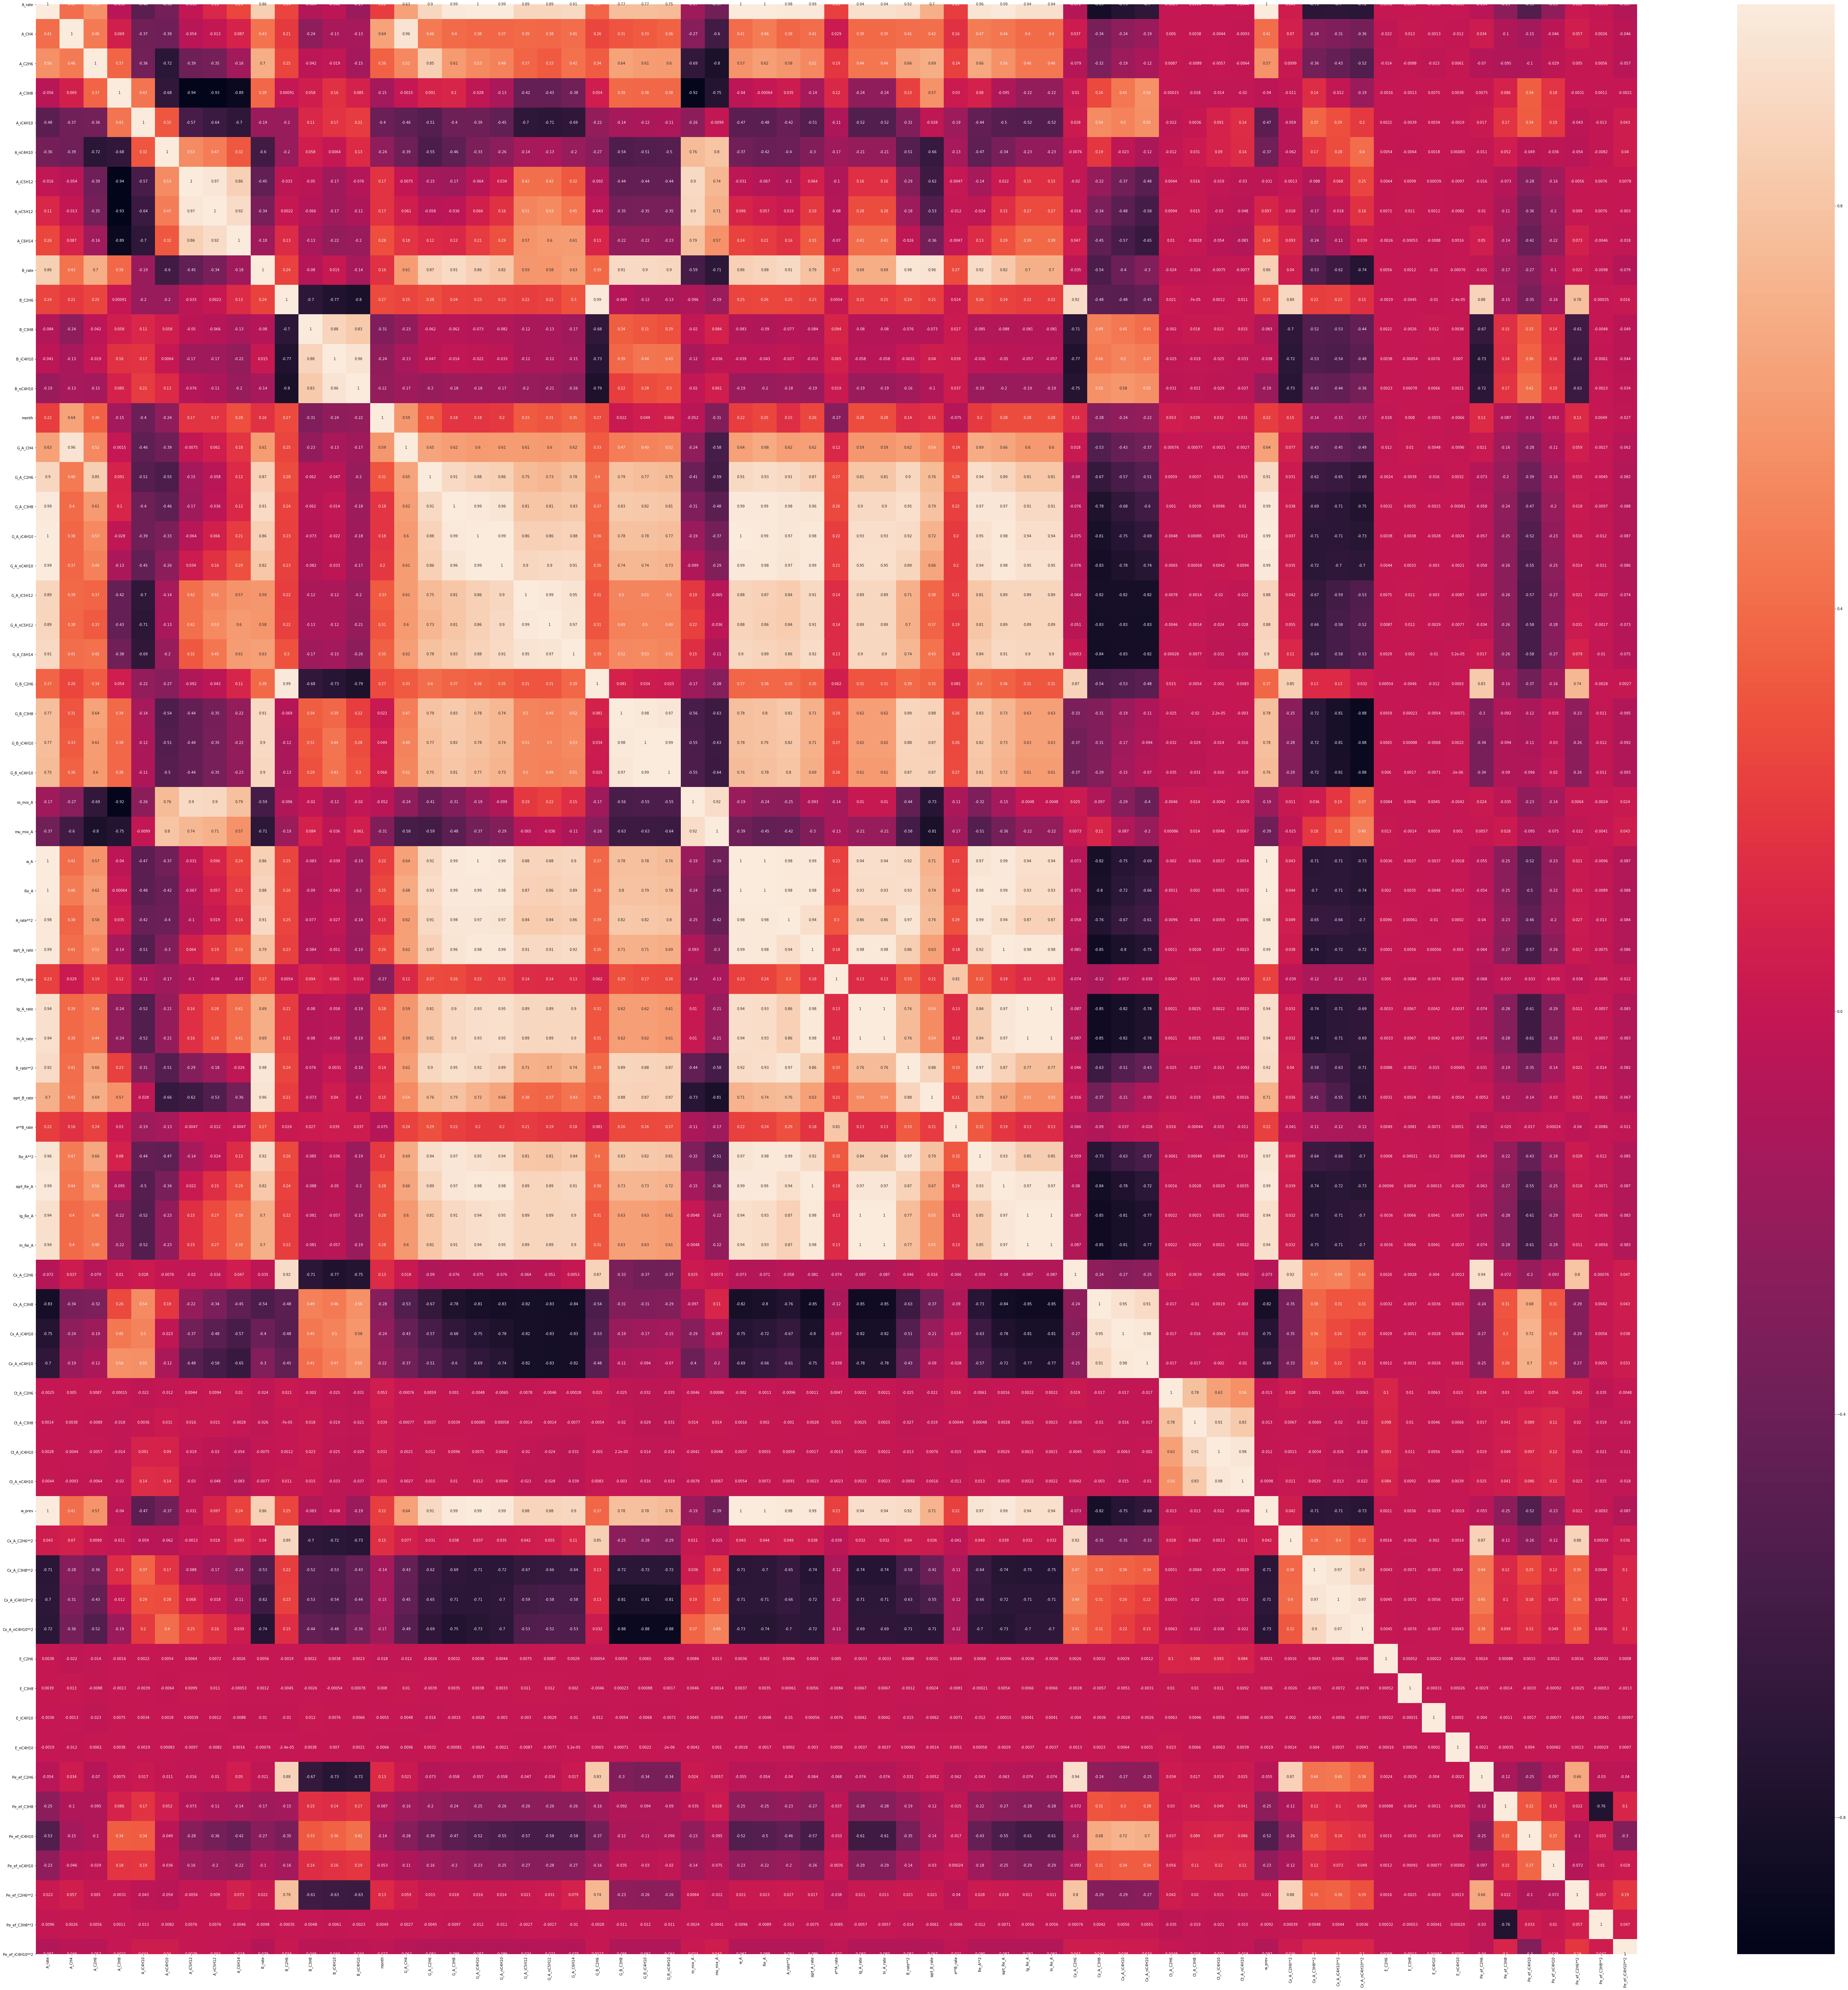

In [582]:
plt.figure(figsize=(100,100))
sns.heatmap(data.corr(), annot=True)

In [583]:
corrMatrix = pd.DataFrame()
corrMatrix['x'] = x.columns
corrMatrix['G_B_C2H6'] = np.array(x.corrwith(data['G_B_C2H6']))
corrMatrix['G_B_C3H8'] = np.array(x.corrwith(data['G_B_C3H8']))
corrMatrix['G_B_iC4H10'] = np.array(x.corrwith(data['G_B_iC4H10']))
corrMatrix['G_B_nC4H10'] = np.array(x.corrwith(data['G_B_nC4H10']))
corrMatrix['B_C2H6'] = np.array(x.corrwith(data['B_C2H6']))
corrMatrix['B_C3H8'] = np.array(x.corrwith(data['B_C3H8']))
corrMatrix['B_iC4H10'] = np.array(x.corrwith(data['B_iC4H10']))
corrMatrix['B_nC4H10'] = np.array(x.corrwith(data['B_nC4H10']))

In [584]:
corrMatrix

x  G_B_C2H6  G_B_C3H8  G_B_iC4H10  G_B_nC4H10    B_C2H6  \
0            A_rate  0.370680  0.771143    0.768626    0.753493  0.244430   
1             A_CH4  0.257065  0.305737    0.329000    0.358630  0.205400   
2            A_C2H6  0.339841  0.642385    0.612782    0.602952  0.249250   
3            A_C3H8  0.053592  0.390908    0.381412    0.381641  0.000908   
4          A_iC4H10 -0.222121 -0.135509   -0.122513   -0.110733 -0.196103   
5          A_nC4H10 -0.272712 -0.540845   -0.514691   -0.503698 -0.196382   
6          A_iC5H12 -0.092087 -0.443852   -0.441115   -0.438124 -0.032799   
7          A_nC5H12 -0.042554 -0.353680   -0.346936   -0.350911  0.002225   
8           A_C6H14  0.105100 -0.222083   -0.217770   -0.228544  0.133833   
9            B_rate  0.388116  0.908737    0.904158    0.900551  0.239711   
10            month  0.268938  0.022351    0.048874    0.066375  0.269336   
11          G_A_CH4  0.329964  0.474709    0.493945    0.515167  0.247292   
12         G_A_C2H6  0.402805  0.790738    0.768362    0.751940  0.278736   
13         G_A_C3H8  0.370308  0.832210    0.824563    0.807696  0.236429   
14       G_A_iC4H10  0.356658  0.783010    0.782386    0.767515  0.229216   
15       G_A_nC4H10  0.348129  0.736589    0.740071    0.726837  0.226226   
16       G_A_iC5H12  0.306740  0.504566    0.508338    0.501617  0.216935   
17       G_A_nC5H12  0.309616  0.490187    0.497789    0.487475  0.221414   
18        G_A_C6H14  0.386704  0.519488    0.525730    0.510437  0.297288   
19         ro_mix_A -0.173593 -0.562685   -0.547938   -0.549205 -0.095902   
20         mu_mix_A -0.278632 -0.633251   -0.627291   -0.637015 -0.186453   
21              w_A  0.372399  0.779142    0.775897    0.760677  0.245150   
22             Re_A  0.384606  0.795146    0.790842    0.777388  0.255230   
23        A_rate**2  0.386117  0.820646    0.815863    0.800528  0.247793   
24      sqrt_A_rate  0.348051  0.711388    0.709669    0.694613  0.233711   
25        e**A_rate  0.061971  0.290265    0.272965    0.264891  0.005355   
26        lg_A_rate  0.310878  0.621008    0.620308    0.605402  0.212720   
27        ln_A_rate  0.310878  0.621008    0.620308    0.605402  0.212720   
28        B_rate**2  0.393465  0.887422    0.881997    0.873835  0.244000   
29      sqrt_B_rate  0.353079  0.875172    0.870580    0.872971  0.213870   
30        e**B_rate  0.081281  0.260800    0.261377    0.273567  0.023729   
31          Re_A**2  0.400699  0.831708    0.823861    0.810876  0.261309   
32        sqrt_Re_A  0.359229  0.734665    0.732018    0.717998  0.241676   
33          lg_Re_A  0.314407  0.629028    0.628220    0.613534  0.215114   
34          ln_Re_A  0.314407  0.629028    0.628220    0.613534  0.215114   
35        Cx_A_C2H6  0.873398 -0.331268   -0.370764   -0.372330  0.924355   
36        Cx_A_C3H8 -0.544002 -0.305719   -0.309781   -0.293886 -0.482065   
37      Cx_A_iC4H10 -0.525295 -0.188590   -0.170422   -0.153080 -0.484346   
38      Cx_A_nC4H10 -0.478669 -0.110939   -0.094390   -0.069641 -0.449591   
39        Ct_A_C2H6  0.014953 -0.025469   -0.031627   -0.035344  0.020769   
40        Ct_A_C3H8 -0.005362 -0.019826   -0.028921   -0.030710 -0.000070   
41      Ct_A_iC4H10 -0.001039  0.000022   -0.013660   -0.015790  0.001250   
42      Ct_A_nC4H10  0.008253 -0.002983   -0.016456   -0.018963  0.010652   
43           w_prev  0.372402  0.779416    0.776342    0.761166  0.245081   
44     Cx_A_C2H6**2  0.854461 -0.253553   -0.278372   -0.286489  0.894871   
45     Cx_A_C3H8**2  0.127226 -0.717429   -0.722283   -0.716640  0.219506   
46   Cx_A_iC4H10**2  0.128266 -0.808320   -0.808163   -0.806616  0.233746   
47   Cx_A_nC4H10**2  0.032134 -0.880395   -0.879093   -0.879898  0.150469   
48           E_C2H6  0.000537  0.005899    0.006526    0.005991 -0.001916   
49           E_C3H8 -0.004582  0.000227    0.000884    0.001717 -0.004509   
50         E_iC4H10 -0.011600 -0.005373   -0.006771   -0.007147 -0.010207   
51         E_n

In [585]:
for i in corrMatrix.drop(labels='x', axis=1).columns:
    print(i + ' = ' , sum(corrMatrix[i].apply(abs)))

G_B_C2H6 =  16.331261510491668
G_B_C3H8 =  25.877832593910828
G_B_iC4H10 =  25.884743013123785
G_B_nC4H10 =  25.60451458394835
B_C2H6 =  13.286717496224899
B_C3H8 =  9.731024337668012
B_iC4H10 =  9.472345831569283
B_nC4H10 =  12.421384532748634


In [586]:
corrMatrix[(corrMatrix['G_B_C2H6'] > 0.3) | (corrMatrix['G_B_C2H6'] < -0.3)][['x', 'G_B_C2H6']]

x  G_B_C2H6
0          A_rate  0.370680
2          A_C2H6  0.339841
9          B_rate  0.388116
11        G_A_CH4  0.329964
12       G_A_C2H6  0.402805
13       G_A_C3H8  0.370308
14     G_A_iC4H10  0.356658
15     G_A_nC4H10  0.348129
16     G_A_iC5H12  0.306740
17     G_A_nC5H12  0.309616
18      G_A_C6H14  0.386704
21            w_A  0.372399
22           Re_A  0.384606
23      A_rate**2  0.386117
24    sqrt_A_rate  0.348051
26      lg_A_rate  0.310878
27      ln_A_rate  0.310878
28      B_rate**2  0.393465
29    sqrt_B_rate  0.353079
31        Re_A**2  0.400699
32      sqrt_Re_A  0.359229
33        lg_Re_A  0.314407
34        ln_Re_A  0.314407
35      Cx_A_C2H6  0.873398
36      Cx_A_C3H8 -0.544002
37    Cx_A_iC4H10 -0.525295
38    Cx_A_nC4H10 -0.478669
43         w_prev  0.372402
44   Cx_A_C2H6**2  0.854461
52     Pe_ef_C2H6  0.830423
54   Pe_ef_iC4H10 -0.373714
56  Pe_ef_C2H6**2  0.742141

In [587]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C2H6','Cx_A_C3H8', 'Cx_A_iC4H10',
          'Cx_A_nC4H10','Cx_A_C2H6**2','Pe_ef_C2H6','G_B_C2H6']]

In [588]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

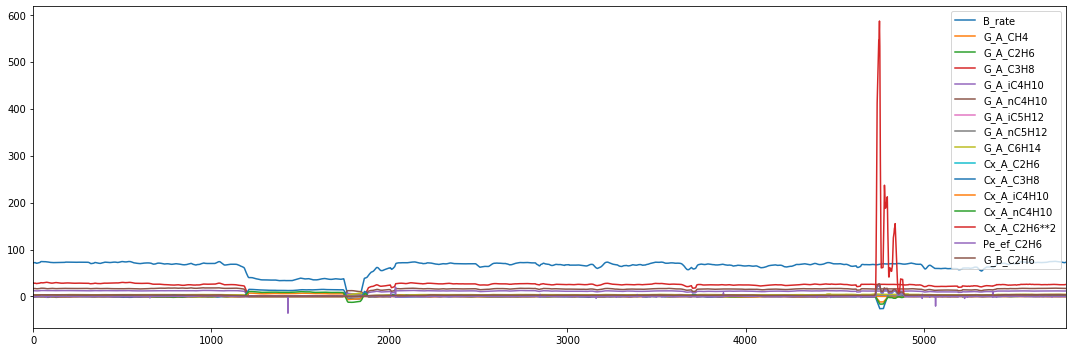

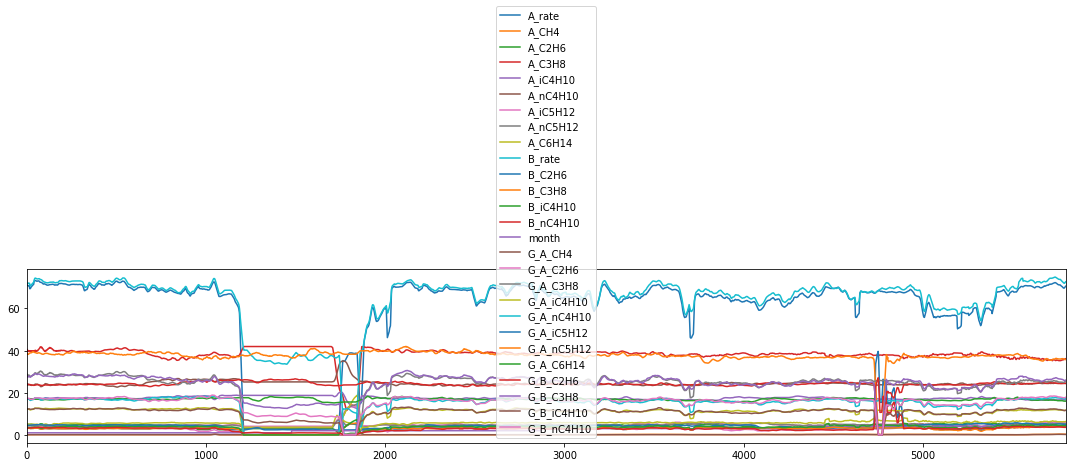

In [589]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [590]:
#запись DataFrame в файл
d.to_csv('train_data_C2H6.csv', sep=',', header=True, index=False)

In [591]:
corrMatrix[(corrMatrix['G_B_C3H8'] > 0.3) | (corrMatrix['G_B_C3H8'] < -0.3)][['x', 'G_B_C3H8']]

x  G_B_C3H8
0           A_rate  0.771143
1            A_CH4  0.305737
2           A_C2H6  0.642385
3           A_C3H8  0.390908
5         A_nC4H10 -0.540845
6         A_iC5H12 -0.443852
7         A_nC5H12 -0.353680
9           B_rate  0.908737
11         G_A_CH4  0.474709
12        G_A_C2H6  0.790738
13        G_A_C3H8  0.832210
14      G_A_iC4H10  0.783010
15      G_A_nC4H10  0.736589
16      G_A_iC5H12  0.504566
17      G_A_nC5H12  0.490187
18       G_A_C6H14  0.519488
19        ro_mix_A -0.562685
20        mu_mix_A -0.633251
21             w_A  0.779142
22            Re_A  0.795146
23       A_rate**2  0.820646
24     sqrt_A_rate  0.711388
26       lg_A_rate  0.621008
27       ln_A_rate  0.621008
28       B_rate**2  0.887422
29     sqrt_B_rate  0.875172
31         Re_A**2  0.831708
32       sqrt_Re_A  0.734665
33         lg_Re_A  0.629028
34         ln_Re_A  0.629028
35       Cx_A_C2H6 -0.331268
36       Cx_A_C3H8 -0.305719
43          w_prev  0.779416
45    Cx_A_C3H8**2 -0.717429
46  Cx_A_iC4H10**2 -0.808320
47  Cx_A_nC4H10**2 -0.880395
52      Pe_ef_C2H6 -0.301646

In [592]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C2H6','Cx_A_C3H8', 'Cx_A_C3H8**2',
          'Cx_A_iC4H10**2','Cx_A_nC4H10**2','Pe_ef_C2H6','G_B_C3H8']]

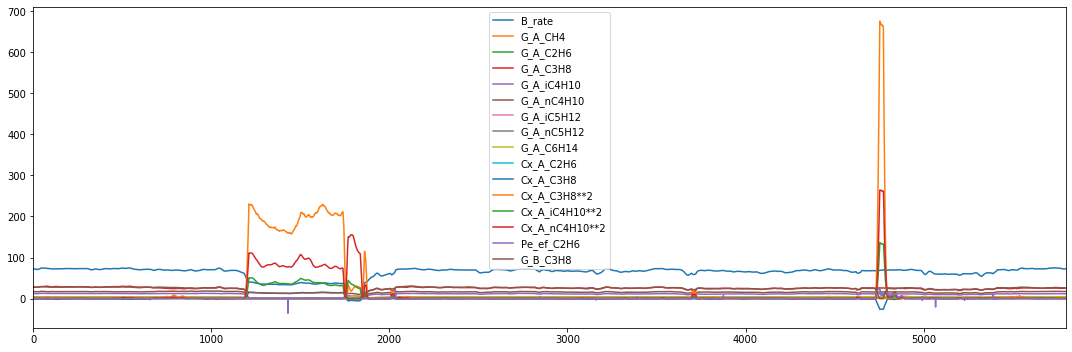

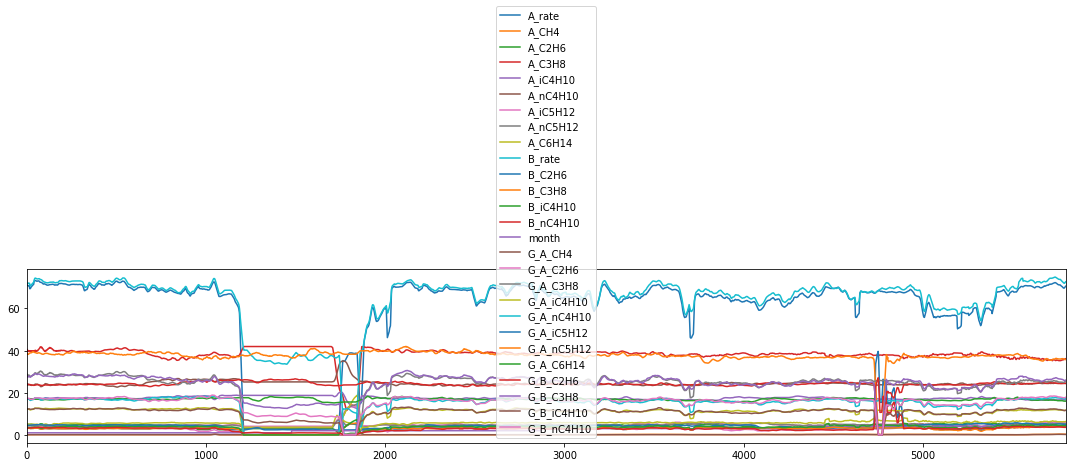

In [593]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [594]:
#запись DataFrame в файл
d.to_csv('train_data_C3H8.csv', sep=',', header=True, index=False)

In [595]:
corrMatrix[(corrMatrix['G_B_iC4H10'] > 0.3) | (corrMatrix['G_B_iC4H10'] < -0.3)][['x', 'G_B_iC4H10']]

x  G_B_iC4H10
0           A_rate    0.768626
1            A_CH4    0.329000
2           A_C2H6    0.612782
3           A_C3H8    0.381412
5         A_nC4H10   -0.514691
6         A_iC5H12   -0.441115
7         A_nC5H12   -0.346936
9           B_rate    0.904158
11         G_A_CH4    0.493945
12        G_A_C2H6    0.768362
13        G_A_C3H8    0.824563
14      G_A_iC4H10    0.782386
15      G_A_nC4H10    0.740071
16      G_A_iC5H12    0.508338
17      G_A_nC5H12    0.497789
18       G_A_C6H14    0.525730
19        ro_mix_A   -0.547938
20        mu_mix_A   -0.627291
21             w_A    0.775897
22            Re_A    0.790842
23       A_rate**2    0.815863
24     sqrt_A_rate    0.709669
26       lg_A_rate    0.620308
27       ln_A_rate    0.620308
28       B_rate**2    0.881997
29     sqrt_B_rate    0.870580
31         Re_A**2    0.823861
32       sqrt_Re_A    0.732018
33         lg_Re_A    0.628220
34         ln_Re_A    0.628220
35       Cx_A_C2H6   -0.370764
36       Cx_A_C3H8   -0.309781
43          w_prev    0.776342
45    Cx_A_C3H8**2   -0.722283
46  Cx_A_iC4H10**2   -0.808163
47  Cx_A_nC4H10**2   -0.879093
52      Pe_ef_C2H6   -0.340005

In [596]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C2H6','Cx_A_C3H8', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
          'Cx_A_iC4H10**2','Cx_A_nC4H10**2','Pe_ef_C2H6','G_B_iC4H10']]

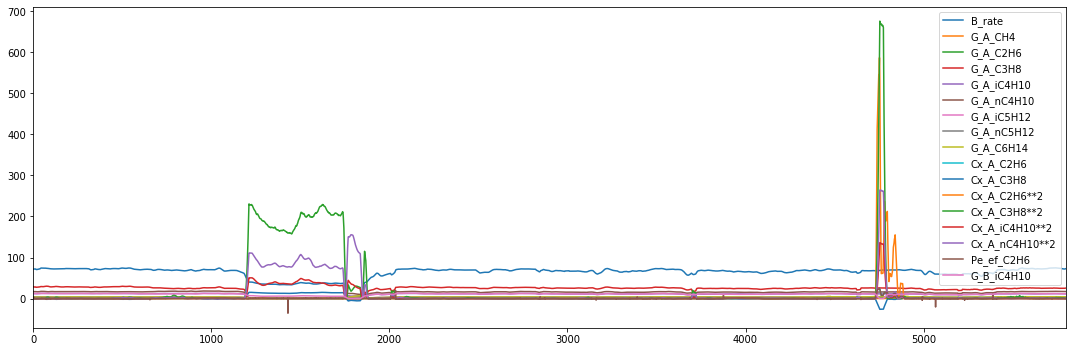

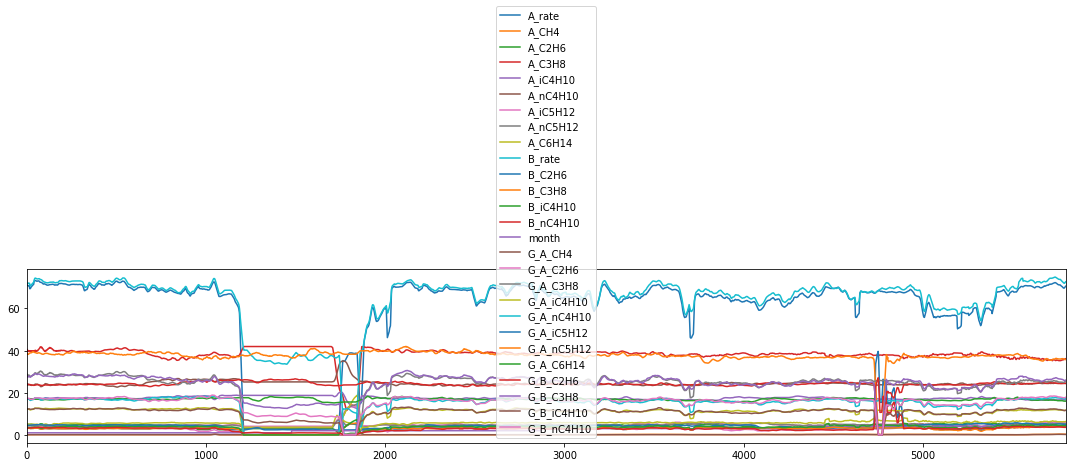

In [597]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [598]:
#запись DataFrame в файл
d.to_csv('train_data_iC4H10.csv', sep=',', header=True, index=False)

In [599]:
corrMatrix[(corrMatrix['G_B_nC4H10'] > 0.3) | (corrMatrix['G_B_nC4H10'] < -0.3)][['x','G_B_nC4H10']] 

x  G_B_nC4H10
0           A_rate    0.753493
1            A_CH4    0.358630
2           A_C2H6    0.602952
3           A_C3H8    0.381641
5         A_nC4H10   -0.503698
6         A_iC5H12   -0.438124
7         A_nC5H12   -0.350911
9           B_rate    0.900551
11         G_A_CH4    0.515167
12        G_A_C2H6    0.751940
13        G_A_C3H8    0.807696
14      G_A_iC4H10    0.767515
15      G_A_nC4H10    0.726837
16      G_A_iC5H12    0.501617
17      G_A_nC5H12    0.487475
18       G_A_C6H14    0.510437
19        ro_mix_A   -0.549205
20        mu_mix_A   -0.637015
21             w_A    0.760677
22            Re_A    0.777388
23       A_rate**2    0.800528
24     sqrt_A_rate    0.694613
26       lg_A_rate    0.605402
27       ln_A_rate    0.605402
28       B_rate**2    0.873835
29     sqrt_B_rate    0.872971
31         Re_A**2    0.810876
32       sqrt_Re_A    0.717998
33         lg_Re_A    0.613534
34         ln_Re_A    0.613534
35       Cx_A_C2H6   -0.372330
43          w_prev    0.761166
45    Cx_A_C3H8**2   -0.716640
46  Cx_A_iC4H10**2   -0.806616
47  Cx_A_nC4H10**2   -0.879898
52      Pe_ef_C2H6   -0.341580

In [600]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C2H6','Cx_A_C3H8', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
          'Cx_A_iC4H10**2','Cx_A_nC4H10**2','Pe_ef_C2H6','G_B_nC4H10']]

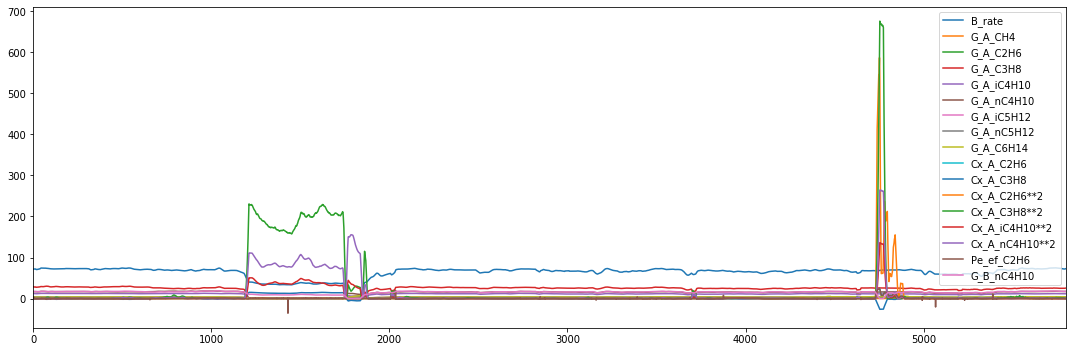

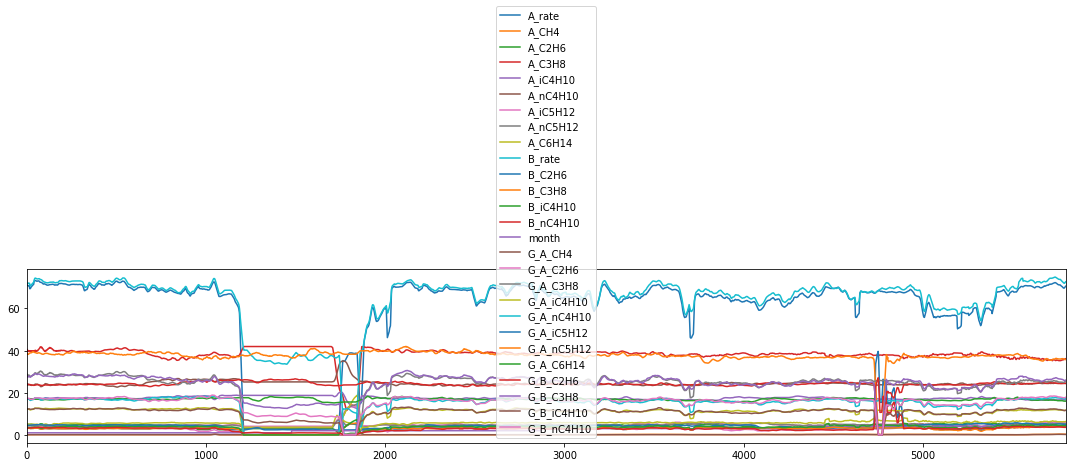

In [601]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [602]:
#запись DataFrame в файл
d.to_csv('train_data_nC4H10.csv', sep=',', header=True, index=False)

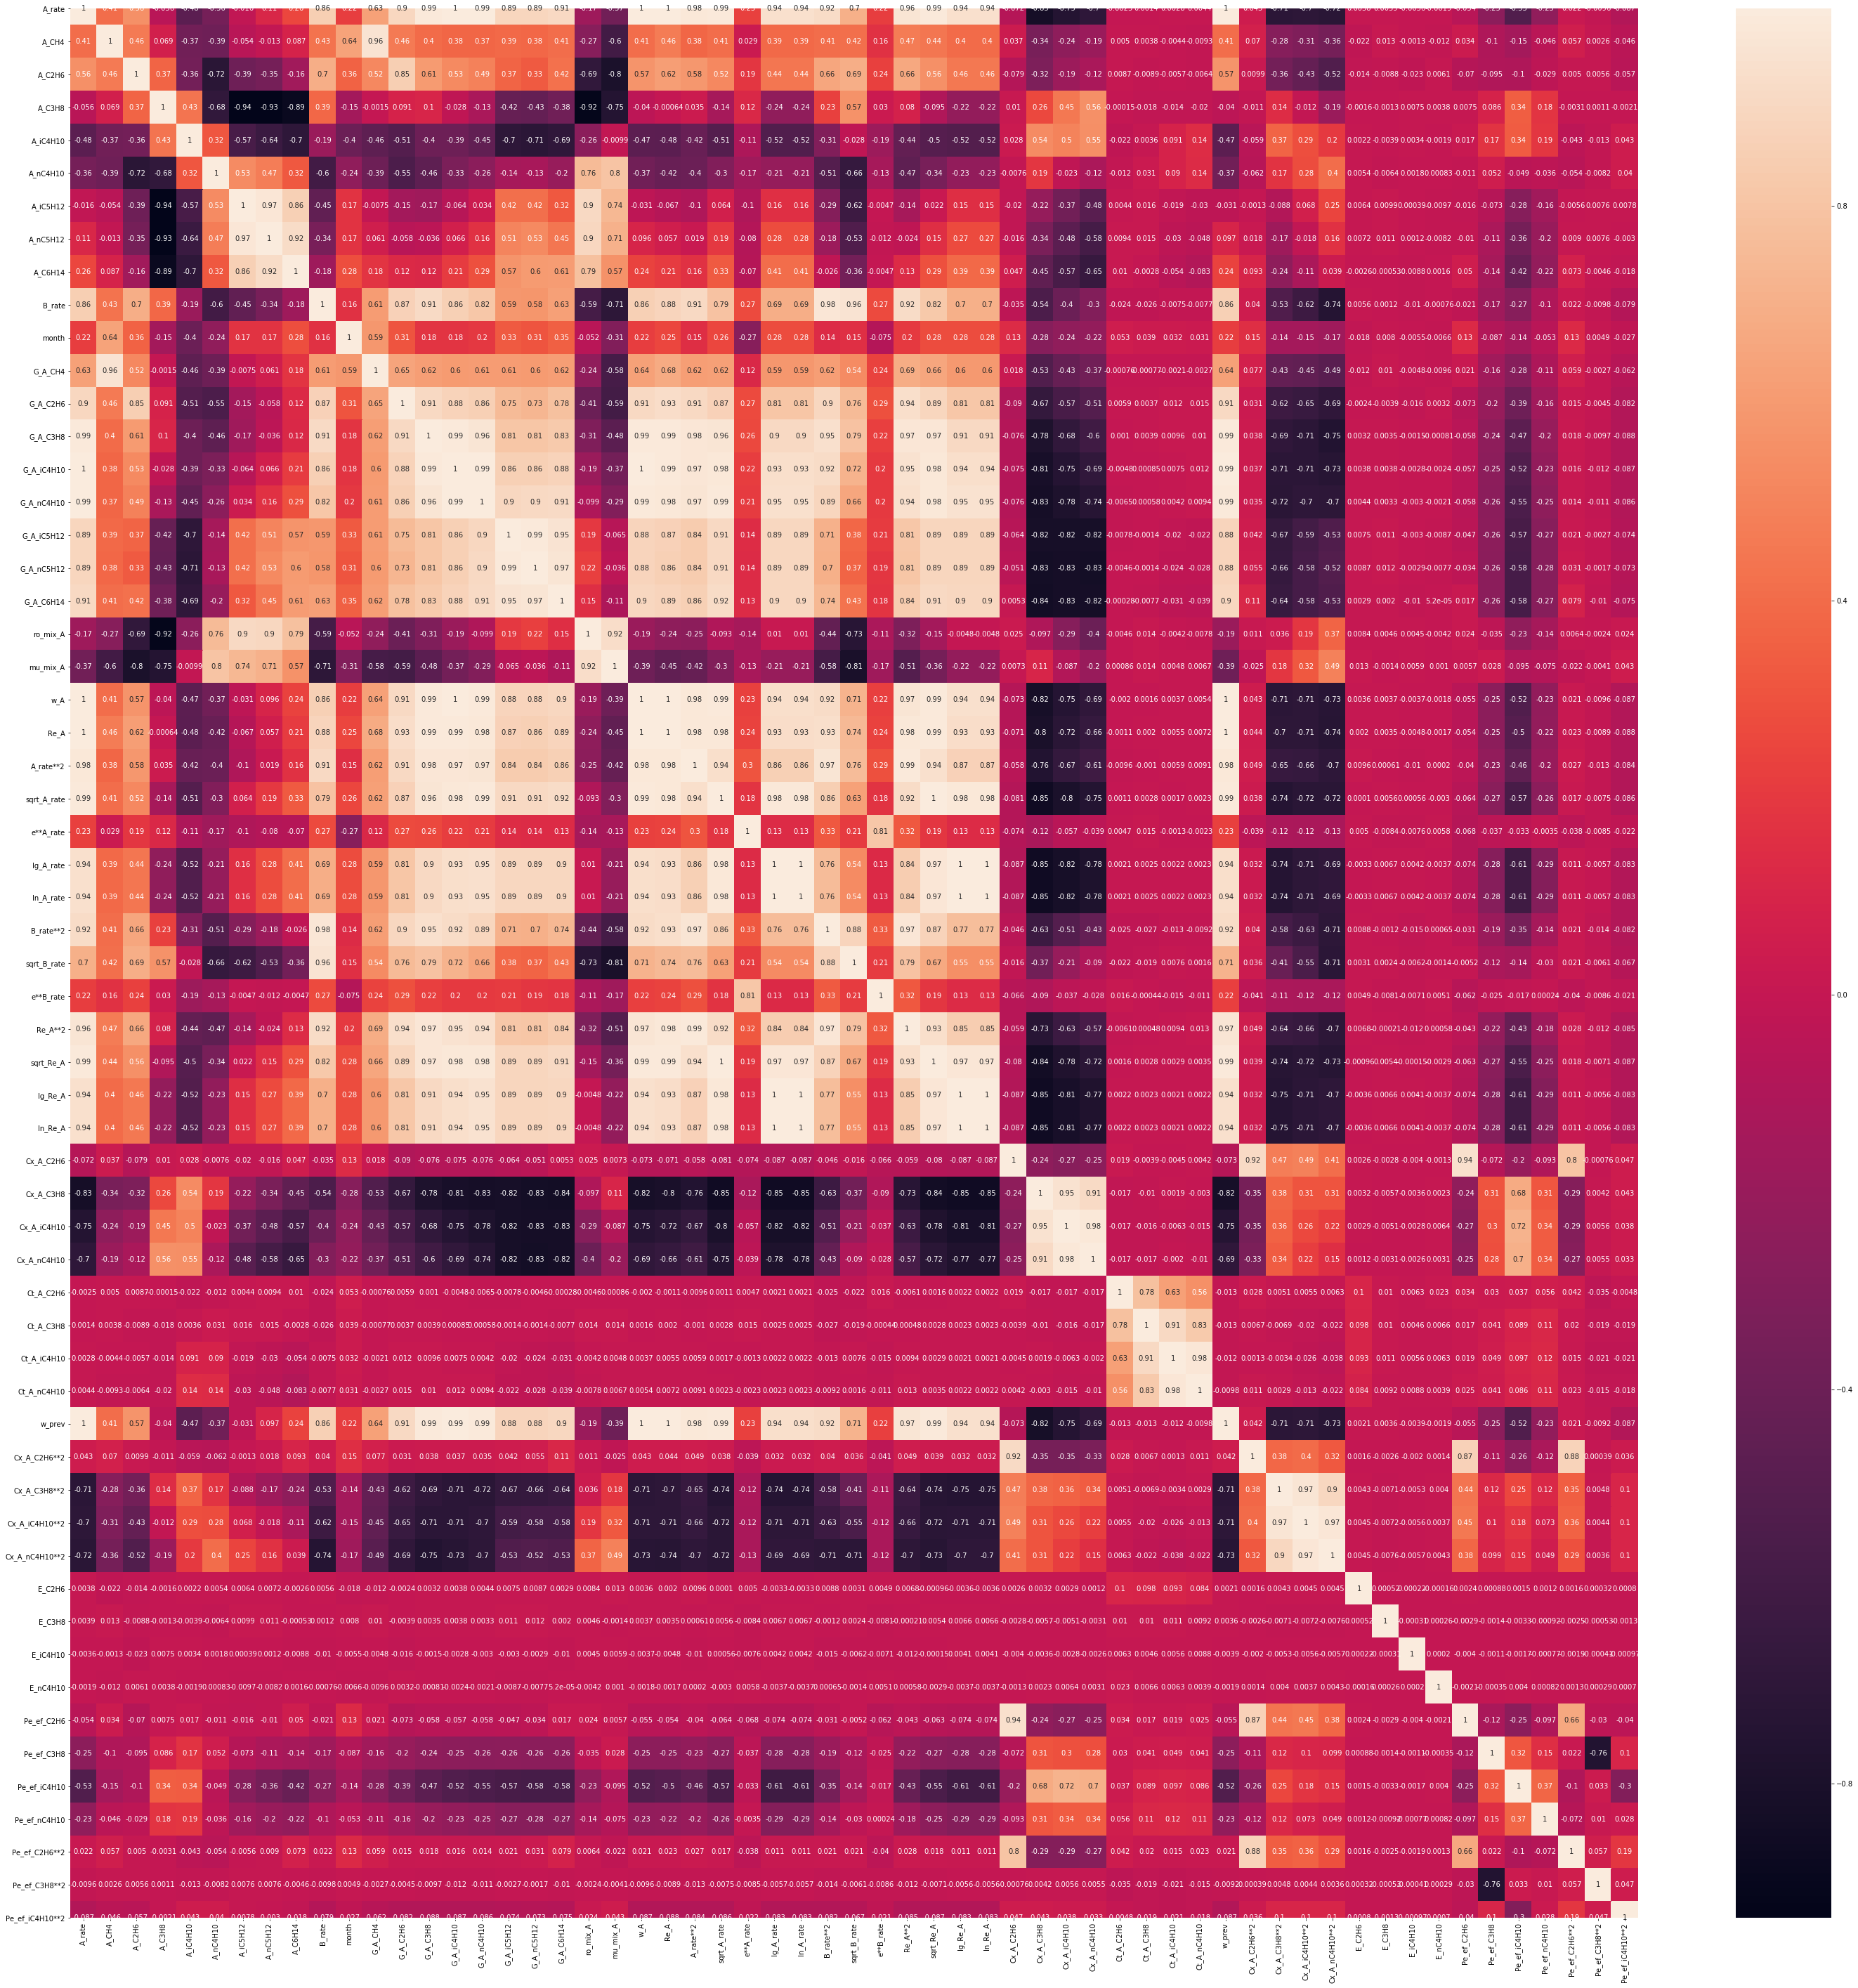

In [603]:
plt.figure(figsize=(50,50))
sns.heatmap(x.corr(), annot=True)

In [604]:
#запись DataFrame в файл
data.to_csv('train_data.csv', sep=',', header=True, index=False)

1. ГОСТ 28656-90
2. "Природные и искусственные газы. Учебник для техникумов. 4-е изд. 1978 г" Рябцев Н.И.
3. Wikipedia

In [605]:
#!cat train_data.csv

## Обработаем test_features

In [606]:
monthList =[]
for i in test_features['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [607]:
test_features['month'] = monthList

In [608]:
test_features = test_features.ffill(axis = 0)
test_features.isnull().sum()

timestamp    0
A_rate       0
A_CH4        0
A_C2H6       0
A_C3H8       0
A_iC4H10     0
A_nC4H10     0
A_iC5H12     0
A_nC5H12     0
A_C6H14      0
B_rate       0
month        0
dtype: int64

In [609]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  month  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009      5  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833      5  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268      5  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744      5  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447      5  
...         ...        ...       ...       ...       ...        ...    ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026      7  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451      7  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878      7  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867      7  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667      7  

[3984 rows x 12 columns]

In [610]:
test_features_prev = test_features
test_features = test_features.rolling(24, min_periods=0).mean()

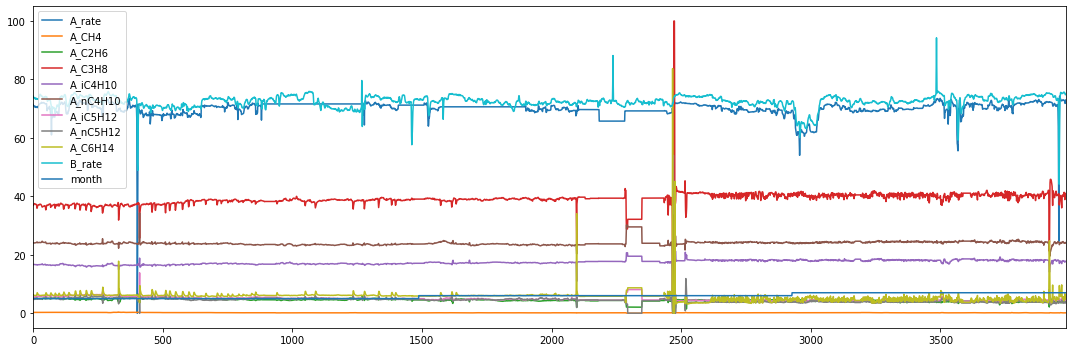

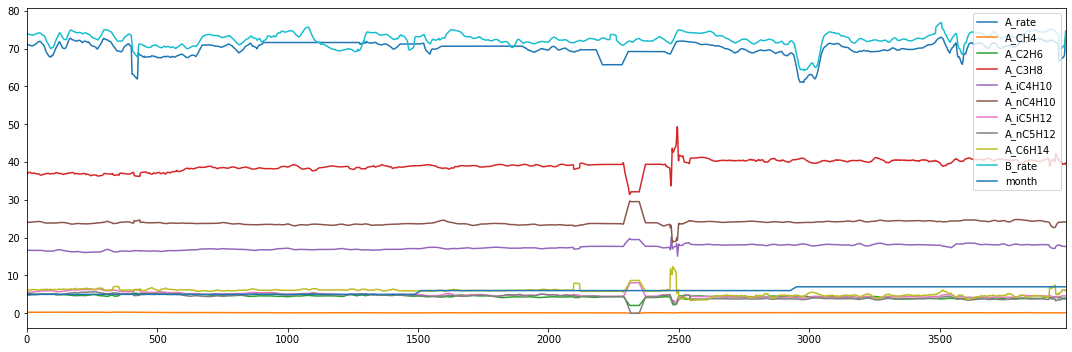

In [611]:
plt.rcParams["figure.figsize"] = (15,5)
test_features_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
test_features[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [612]:
test_features['timestamp'] = test_features_prev['timestamp']

In [613]:
test_features['G_A_CH4'] = test_features['A_rate'] * test_features['A_CH4'] / 100
test_features['G_A_C2H6'] = test_features['A_rate'] * test_features['A_C2H6'] / 100
test_features['G_A_C3H8'] = test_features['A_rate'] * test_features['A_C3H8'] / 100
test_features['G_A_iC4H10'] = test_features['A_rate'] * test_features['A_iC4H10'] / 100
test_features['G_A_nC4H10'] = test_features['A_rate'] * test_features['A_nC4H10'] / 100
test_features['G_A_iC5H12'] = test_features['A_rate'] * test_features['A_iC5H12'] / 100
test_features['G_A_nC5H12'] = test_features['A_rate'] * test_features['A_nC5H12'] / 100
test_features['G_A_C6H14'] = test_features['A_rate'] * test_features['A_C6H14'] / 100

In [614]:
test_features['ro_mix_A'] = ((test_features['A_CH4'] / 100 / ro_CH4) + (test_features['A_C2H6'] / 100 / ro_C2H6) 
                  + (test_features['A_C3H8'] / 100 / ro_C3H8) + (test_features['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (test_features['A_nC4H10'] / 100 / ro_nC4H10) + (test_features['A_iC5H12'] / 100 / ro_iC5H12)
                  + (test_features['A_nC5H12'] / 100 / ro_nC5H12) + (test_features['A_C6H14'] / 100 / ro_C6H14))**-1

In [615]:
test_features['mu_mix_A'] = (((test_features['A_CH4'] / 100) * (test_features['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((test_features['A_C2H6'] / 100) * (test_features['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((test_features['A_C3H8'] / 100) * (test_features['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((test_features['A_iC4H10'] / 100) * (test_features['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((test_features['A_nC4H10'] / 100) * (test_features['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((test_features['A_iC5H12'] / 100) * (test_features['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((test_features['A_nC5H12'] / 100) * (test_features['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((test_features['A_C6H14'] / 100) * (test_features['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [616]:
test_features['w_A'] = (4*test_features['A_rate']*0.278)/(3.14*test_features['ro_mix_A']*0.16)
test_features['Re_A'] = (4*test_features['A_rate']*0.278)/(3.14*0.4*test_features['mu_mix_A'])

In [617]:
test_features['A_rate**2'] = test_features['A_rate']**2
test_features['sqrt_A_rate'] = test_features['A_rate'].apply(m.sqrt)
test_features['e**A_rate'] = test_features['A_rate'].apply(m.exp)
test_features['lg_A_rate'] = test_features['A_rate'].apply(m.log10)
test_features['ln_A_rate'] = test_features['A_rate'].apply(m.log)

test_features['B_rate**2'] = test_features['B_rate']**2
test_features['sqrt_B_rate'] = test_features['B_rate'].apply(m.sqrt)
test_features['e**B_rate'] = test_features['B_rate'].apply(m.exp)


test_features['Re_A**2'] = test_features['Re_A']**2
test_features['sqrt_Re_A'] = test_features['Re_A'].apply(m.sqrt)

test_features['lg_Re_A'] = test_features['Re_A'].apply(m.log10)
test_features['ln_Re_A'] = test_features['Re_A'].apply(m.log)

In [618]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.428342  0.267832  5.135159  36.816480  16.632260  24.062587   
1     71.176730  0.268148  5.142402  36.842752  16.642065  24.066193   
2     71.115060  0.268979  5.146473  36.920156  16.665032  24.079513   
3     71.079396  0.270545  5.167520  37.036162  16.669608  24.065133   
4     71.059532  0.271448  5.182303  37.118647  16.668459  24.052754   
...         ...       ...       ...        ...        ...        ...   
3979  68.487747  0.119471  4.016049  39.564136  17.671798  24.114457   
3980  69.752031  0.119286  4.001332  39.483951  17.646161  24.108275   
3981  71.719374  0.119306  3.985564  39.438651  17.630275  24.109326   
3982  72.732759  0.120195  3.989727  39.571727  17.644989  24.116875   
3983  72.899001  0.121329  3.998461  39.735921  17.676121  24.143933   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate  month            timestamp  \
0     5.696004  4.939430  6.395286  74.273009    5.0  2020-05-01 00:00:00   
1     5.686194  4.925651  6.371121  74.167421    5.0  2020-05-01 00:30:00   
2     5.649087  4.886606  6.328293  74.063703    5.0  2020-05-01 01:00:00   
3     5.615526  4.847676  6.271631  73.985463    5.0  2020-05-01 01:30:00   
4     5.597400  4.823918  6.228729  73.928060    5.0  2020-05-01 02:00:00   
...        ...       ...       ...        ...    ...                  ...   
3979  4.591459  3.764521  6.107097  71.084681    7.0  2020-07-22 21:30:00   
3980  4.610371  3.788717  6.190751  71.466614    7.0  2020-07-22 22:00:00   
3981  4.622657  3.804659  6.238181  72.491632    7.0  2020-07-22 22:30:00   
3982  4.604864  3.782789  6.116879  73.767143    7.0  2020-07-22 23:00:00   
3983  4.586744  3.759512  5.925320  74.683655    7.0  2020-07-22 23:30:00   

       G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0     0.191308  3.667959  26.297401   11.880148   17.187507    4.068561   
1     0.190859  3.660194  26.223466   11.845278   17.129529    4.047247   
2     0.191285  3.659918  26.255791   11.851348   17.124160    4.017352   
3     0.192301  3.673042  26.325080   11.848657   17.105351    3.991482   
4     0.192890  3.682521  26.376337   11.844529   17.091774    3.977487   
...        ...       ...        ...         ...         ...         ...   
3979  0.081823  2.750501  27.096585   12.103016   16.515449    3.144587   
3980  0.083204  2.791011  27.540858   12.308556   16.816012    3.215828   
3981  0.085566  2.858422  28.285153   12.644323   17.291058    3.315341   
3982  0.087421  2.901839  28.781609   12.833688   17.540869    3.349245   
3983  0.088447  2.914838  28.967090   12.885716   17.600686    3.343691   

      G_A_nC5H12  G_A_C6H14    ro_mix_A  mu_mix_A       w_A           Re_A  \
0       3.528153   4.568047  562.574167  0.000151  0.281026  419019.690291   
1       3.505918   4.534756  562.513894  0.000151  0.280066  417716.031332   
2       3.475113   4.500369  562.390951  0.000151  0.279884  417677.086653   
3       3.445699   4.457838  562.189616  0.000151  0.279844  418092.480177   
4       3.427853   4.426106  562.050079  0.000150  0.279835  418391.849005   
...          ...        ...         ...       ...       ...            ...   
3979    2.578236   4.182613  563.113161  0.000159  0.269198  381668.536235   
3980    2.642707   4.318175  563.278606  0.000159  0.274087  388351.009372   
3981    2.728678   4.473984  563.392988  0.000159  0.281761  399038.107532   
3982    2.751327   4.448975  563.197778  0.000159  0.285841  405156.371466   
3983    2.740647   4.319499  562.923043  0.000159  0.286634  406743.210802   

        A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate  \
0     5102.008078     8.451529  1.049385e+31   1.853871   4.268695   
1     5066.126880     8.436630  8.159453e+30   1.852338   4.265166   
2     5057.351702     8.432975  7.671459e+30   1.851962   4.264299   
3     5052.280554     8.430860  7.402689e+30   1.851744   4.263798   
4     5049.457156     8.429682 

In [619]:
last_line

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
5797  70.537988  0.301398  5.055399  36.150185  16.628783  24.371108   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
5797  5.888891    5.1987  6.350054  72.652285  5.023277  35.755455  16.026055   

       B_nC4H10            timestamp  month  G_A_CH4  G_A_C2H6   G_A_C3H8  \
5797  24.525772  2020-04-30 23:30:00      4   0.2126  3.565976  25.499613   

      G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6  \
5797   11.729609   17.190889    4.153906    3.667058     4.4792  3.649526   

       G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A  \
5797  25.977155   11.643295   17.818534  563.204786   0.00015  0.277212   

               Re_A  A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  \
5797  415585.912821  4975.6078      8.39869  4.307835e+30   1.848423   

      ln_A_rate    B_rate**2  sqrt_B_rate     e**B_rate       Re_A**2  \
5797   4.256151  5278.354546     8.523631  3.568507e+31  1.727117e+11   

       sqrt_Re_A   lg_Re_A    ln_Re_A  Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  \
5797  644.659532  5.618661  12.937445   0.073978   0.505996    -0.090163   

      Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10    w_prev  \
5797     0.607818  -0.001146   0.051962     0.014534     0.013684  0.276829   

      Cx_A_C2H6**2  Cx_A_C3H8**2  Cx_A_iC4H10**2  Cx_A_nC4H10**2    E_C2H6  \
5797      0.005473      0.256032        0.008129        0.369442  3.532605   

        E_C3H8  E_iC4H10  E_nC4H10  Pe_ef_C2H6  Pe_ef_C3H8  Pe_ef_iC4H10  \
5797  0.750048 -1.282458  0.492486    0.078364    0.369081     -0.215858   

      Pe_ef_nC4H10  Pe_ef_C2H6**2  Pe_ef_C3H8**2  Pe_ef_iC4H10**2  
5797      0.562105       0.006141       0.136221         0.046595

In [620]:
test_features = pd.concat([last_line,test_features], axis=0)
test_features = test_features.reset_index(drop=True)

In [621]:
test_features

A_C2H6     A_C3H8   A_C6H14     A_CH4   A_iC4H10  A_iC5H12   A_nC4H10  \
0     5.055399  36.150185  6.350054  0.301398  16.628783  5.888891  24.371108   
1     5.135159  36.816480  6.395286  0.267832  16.632260  5.696004  24.062587   
2     5.142402  36.842752  6.371121  0.268148  16.642065  5.686194  24.066193   
3     5.146473  36.920156  6.328293  0.268979  16.665032  5.649087  24.079513   
4     5.167520  37.036162  6.271631  0.270545  16.669608  5.615526  24.065133   
...        ...        ...       ...       ...        ...       ...        ...   
3980  4.016049  39.564136  6.107097  0.119471  17.671798  4.591459  24.114457   
3981  4.001332  39.483951  6.190751  0.119286  17.646161  4.610371  24.108275   
3982  3.985564  39.438651  6.238181  0.119306  17.630275  4.622657  24.109326   
3983  3.989727  39.571727  6.116879  0.120195  17.644989  4.604864  24.116875   
3984  3.998461  39.735921  5.925320  0.121329  17.676121  4.586744  24.143933   

      A_nC5H12     A_rate    A_rate**2    B_C2H6     B_C3H8   B_iC4H10  \
0     5.198700  70.537988  4975.607800  5.023277  35.755455  16.026055   
1     4.939430  71.428342  5102.008078       NaN        NaN        NaN   
2     4.925651  71.176730  5066.126880       NaN        NaN        NaN   
3     4.886606  71.115060  5057.351702       NaN        NaN        NaN   
4     4.847676  71.079396  5052.280554       NaN        NaN        NaN   
...        ...        ...          ...       ...        ...        ...   
3980  3.764521  68.487747  4690.571518       NaN        NaN        NaN   
3981  3.788717  69.752031  4865.345870       NaN        NaN        NaN   
3982  3.804659  71.719374  5143.668607       NaN        NaN        NaN   
3983  3.782789  72.732759  5290.054298       NaN        NaN        NaN   
3984  3.759512  72.899001  5314.264347       NaN        NaN        NaN   

       B_nC4H10     B_rate    B_rate**2  Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  \
0     24.525772  72.652285  5278.354546  -0.001146   0.051962     0.014534   
1           NaN  74.273009  5516.479837        NaN        NaN          NaN   
2           NaN  74.167421  5500.806318        NaN        NaN          NaN   
3           NaN  74.063703  5485.432125        NaN        NaN          NaN   
4           NaN  73.985463  5473.848776        NaN        NaN          NaN   
...         ...        ...          ...        ...        ...          ...   
3980        NaN  71.084681  5053.031900        NaN        NaN          NaN   
3981        NaN  71.466614  5107.476904        NaN        NaN          NaN   
3982        NaN  72.491632  5255.036768        NaN        NaN          NaN   
3983        NaN  73.767143  5441.591397        NaN        NaN          NaN   
3984        NaN  74.683655  5577.648288        NaN        NaN          NaN   

      Ct_A_nC4H10  Cx_A_C2H6  Cx_A_C2H6**2  Cx_A_C3H8  Cx_A_C3H8**2  \
0        0.013684   0.073978      0.005473   0.505996      0.256032   
1             NaN        NaN           NaN        NaN           NaN   
2             NaN        NaN           NaN        NaN           NaN   
3             NaN        NaN           NaN        NaN           NaN   
4             NaN        NaN           NaN        NaN           NaN   
...           ...        ...           ...        ...           ...   
3980          NaN        NaN           NaN        NaN           NaN   
3981          NaN        NaN           NaN        NaN           NaN   
3982          NaN        NaN           NaN        NaN           NaN   
3983          NaN        NaN           NaN        NaN           NaN   
3984          NaN        NaN           NaN        NaN           NaN   

      Cx_A_iC4H10  Cx_A_iC4H10**2  Cx_A_nC4H10  Cx_A_nC4H10**2    E_C2H6  \
0       -0.090163        0.008129     0.607818        0.369442  3.532605   
1             NaN             NaN          NaN             NaN       NaN   
2             NaN             NaN          NaN             NaN       NaN   
3             NaN             NaN          NaN      

In [622]:
test_features.columns

Index(['A_C2H6', 'A_C3H8', 'A_C6H14', 'A_CH4', 'A_iC4H10', 'A_iC5H12',
       'A_nC4H10', 'A_nC5H12', 'A_rate', 'A_rate**2', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'B_rate', 'B_rate**2', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'Cx_A_C2H6', 'Cx_A_C2H6**2', 'Cx_A_C3H8',
       'Cx_A_C3H8**2', 'Cx_A_iC4H10', 'Cx_A_iC4H10**2', 'Cx_A_nC4H10',
       'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10', 'E_nC4H10',
       'G_A_C2H6', 'G_A_C3H8', 'G_A_C6H14', 'G_A_CH4', 'G_A_iC4H10',
       'G_A_iC5H12', 'G_A_nC4H10', 'G_A_nC5H12', 'G_B_C2H6', 'G_B_C3H8',
       'G_B_iC4H10', 'G_B_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C2H6**2', 'Pe_ef_C3H8',
       'Pe_ef_C3H8**2', 'Pe_ef_iC4H10', 'Pe_ef_iC4H10**2', 'Pe_ef_nC4H10',
       'Re_A', 'Re_A**2', 'e**A_rate', 'e**B_rate', 'lg_A_rate', 'lg_Re_A',
       'ln_A_rate', 'ln_Re_A', 'month', 'mu_mix_A', 'ro_mix_A', 'sqrt_A_rate',
       'sqrt_B_rate', 'sqrt_Re_A', 'timestamp', 'w_A', 'w_prev'],
      dtype='object')

In [623]:
test_features = test_features.drop(labels=['B_C2H6','B_C3H8', 'B_iC4H10', 'B_nC4H10','E_C2H6', 'E_C3H8',
                                           'E_iC4H10','E_nC4H10', 'Pe_ef_iC4H10','Ct_A_C2H6', 'Ct_A_C3H8',
                                           'Ct_A_iC4H10', 'Ct_A_nC4H10','Pe_ef_nC4H10','Pe_ef_C2H6**2',
                                           'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],axis=1)

In [624]:
test_features

A_C2H6     A_C3H8   A_C6H14     A_CH4   A_iC4H10  A_iC5H12   A_nC4H10  \
0     5.055399  36.150185  6.350054  0.301398  16.628783  5.888891  24.371108   
1     5.135159  36.816480  6.395286  0.267832  16.632260  5.696004  24.062587   
2     5.142402  36.842752  6.371121  0.268148  16.642065  5.686194  24.066193   
3     5.146473  36.920156  6.328293  0.268979  16.665032  5.649087  24.079513   
4     5.167520  37.036162  6.271631  0.270545  16.669608  5.615526  24.065133   
...        ...        ...       ...       ...        ...       ...        ...   
3980  4.016049  39.564136  6.107097  0.119471  17.671798  4.591459  24.114457   
3981  4.001332  39.483951  6.190751  0.119286  17.646161  4.610371  24.108275   
3982  3.985564  39.438651  6.238181  0.119306  17.630275  4.622657  24.109326   
3983  3.989727  39.571727  6.116879  0.120195  17.644989  4.604864  24.116875   
3984  3.998461  39.735921  5.925320  0.121329  17.676121  4.586744  24.143933   

      A_nC5H12     A_rate    A_rate**2     B_rate    B_rate**2  Cx_A_C2H6  \
0     5.198700  70.537988  4975.607800  72.652285  5278.354546   0.073978   
1     4.939430  71.428342  5102.008078  74.273009  5516.479837        NaN   
2     4.925651  71.176730  5066.126880  74.167421  5500.806318        NaN   
3     4.886606  71.115060  5057.351702  74.063703  5485.432125        NaN   
4     4.847676  71.079396  5052.280554  73.985463  5473.848776        NaN   
...        ...        ...          ...        ...          ...        ...   
3980  3.764521  68.487747  4690.571518  71.084681  5053.031900        NaN   
3981  3.788717  69.752031  4865.345870  71.466614  5107.476904        NaN   
3982  3.804659  71.719374  5143.668607  72.491632  5255.036768        NaN   
3983  3.782789  72.732759  5290.054298  73.767143  5441.591397        NaN   
3984  3.759512  72.899001  5314.264347  74.683655  5577.648288        NaN   

      Cx_A_C2H6**2  Cx_A_C3H8  Cx_A_C3H8**2  Cx_A_iC4H10  Cx_A_iC4H10**2  \
0         0.005473   0.505996      0.256032    -0.090163        0.008129   
1              NaN        NaN           NaN          NaN             NaN   
2              NaN        NaN           NaN          NaN             NaN   
3              NaN        NaN           NaN          NaN             NaN   
4              NaN        NaN           NaN          NaN             NaN   
...            ...        ...           ...          ...             ...   
3980           NaN        NaN           NaN          NaN             NaN   
3981           NaN        NaN           NaN          NaN             NaN   
3982           NaN        NaN           NaN          NaN             NaN   
3983           NaN        NaN           NaN          NaN             NaN   
3984           NaN        NaN           NaN          NaN             NaN   

      Cx_A_nC4H10  Cx_A_nC4H10**2  G_A_C2H6   G_A_C3H8  G_A_C6H14   G_A_CH4  \
0        0.607818        0.369442  3.565976  25.499613   4.479200  0.212600   
1             NaN             NaN  3.667959  26.297401   4.568047  0.191308   
2             NaN             NaN  3.660194  26.223466   4.534756  0.190859   
3             NaN             NaN  3.659918  26.255791   4.500369  0.191285   
4             NaN             NaN  3.673042  26.325080   4.457838  0.192301   
...           ...             ...       ...        ...        ...       ...   
3980          NaN             NaN  2.750501  27.096585   4.182613  0.081823   
3981          NaN             NaN  2.791011  27.540858   4.318175  0.083204   
3982          NaN             NaN  2.858422  28.285153   4.473984  0.085566   
3983          NaN             NaN  2.901839  28.781609   4.448975  0.087421   
3984          NaN             NaN  2.914838  28.967090   4.319499  0.088447   

      G_A_iC4H10  G_A_iC5H12  G_A_nC4H10  G_A_nC5H12  G_B_C2H6   G_B_C3H8  \
0      11.729609    4.153906   17.190889    3.667058  3.649526  25.977155   
1      11.880148    4.068561   17.187507    3.528153       NaN        NaN   
2      11.845278 

In [625]:
#запись DataFrame в файл
test_features.to_csv('test_data.csv', sep=',', header=True, index=False)